In [ ]:
 import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from tabulate import tabulate

In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def preprocess_imgs(images, arch):
  imgs = None
  img_size = None
  if arch == 'vgg':
    imgs = tf.keras.applications.vgg19.preprocess_input(np.array(images, dtype=object))
    img_size = img_size_vgg_densenet
  elif arch == 'inception':
    imgs = tf.keras.applications.inception_v3.preprocess_input(np.array(images, dtype=object))
    img_size = img_size_inception
  elif arch == 'xception':
    imgs = tf.keras.applications.xception.preprocess_input(np.array(images, dtype=object))
    img_size = img_size_inception
  elif arch == 'densenet':
    imgs = tf.keras.applications.densenet.preprocess_input(np.array(images, dtype=object))
    img_size = img_size_vgg_densenet

  resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_size, img_size),
  ])
  preprocess = lambda x: [resize(img) for img in x]
  return np.array(preprocess(imgs))

In [ ]:
def plot_curves(history, metric, metric_val):
  print(history.history.keys())
  plt.plot(history.history[metric])
  plt.plot(history.history[metric_val])
  plt.title('model {}'.format(metric))
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['treinamento', 'validação'], loc='upper left')
  plt.show()

In [ ]:
def plot_metrics(model, X_test, y_test, labels, model_type, model_name, classifier = 'mlp'):
  pred = None
  if model_type == 'hybrid':
    preds = model.predict_proba(X_test)
    pred = np.argmax(preds, axis=1)
  else:
    preds = model.predict(X_test)
    pred = np.argmax(preds, axis=1)

  ytest = np.argmax(y_test, axis=1)
  cm = confusion_matrix(ytest, pred)
  fp = cm.sum(axis=0) - np.diag(cm)
  fn = cm.sum(axis=1) - np.diag(cm)
  tp = np.diag(cm)
  tn = cm.sum() - (fp + fn + tp)

  specificity = np.mean(tn / (tn+fp))
  sensitivity =  np.mean(tp / (tp + fn))
  acc = accuracy_score(ytest, pred)
  f1 = sklearn.metrics.f1_score(ytest, pred, average='macro')
  rocauc = sklearn.metrics.roc_auc_score(ytest, preds, multi_class = 'ovo')

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()
  print(f'accuracy: {acc}')
  print(classification_report(ytest, pred,target_names=labels))
  print(f"F1-score: {f1}")
  print(f"specificity: {specificity}")
  print(f"sensitivity: {sensitivity}")
  print(f"AUC-ROC: {rocauc}")

  try:
    roc_curve[classifier][model_name]
  except:
    roc_curve[classifier][model_name] = {}

  roc_curve[classifier][model_name]['fpr'] = {}
  roc_curve[classifier][model_name]['tpr'] = {}
  roc_curve[classifier][model_name]['thresh'] ={}

  n_class = 3

  for i in range(n_class):
      roc_curve[classifier][model_name]['fpr'][i], roc_curve[classifier][model_name]['tpr'][i], roc_curve[classifier][model_name]['thresh'][i] = sklearn.metrics.roc_curve(ytest, preds[:,i], pos_label=i)


  if model_type == 'hybrid':
    hybrid_model_results[classifier][model_name] = {}
    hybrid_model_results[classifier][model_name]['accuracy'] = acc
    hybrid_model_results[classifier][model_name]['F1-score'] = f1
    hybrid_model_results[classifier][model_name]["specificity"] = specificity
    hybrid_model_results[classifier][model_name]["sensitivity"] = sensitivity
    hybrid_model_results[classifier][model_name]["AUC-ROC"] = rocauc
  else:
    full_model_results[model_name] = {}
    full_model_results[model_name]['accuracy'] = acc
    full_model_results[model_name]['F1-score'] = f1
    full_model_results[model_name]["specificity"] = specificity
    full_model_results[model_name]["sensitivity"] = sensitivity
    full_model_results[model_name]["AUC-ROC"] = rocauc

In [ ]:
def plot_roc_auc(classifier):
  for model in roc_curve[classifier].values():
    plt.plot(model['fpr'][0], model['tpr'][0], linestyle='--',color='orange', label='Benign vs Rest')
    plt.plot(model['fpr'][1], model['tpr'][1], linestyle='--',color='green', label='Malignant vs Rest')
    plt.plot(model['fpr'][2], model['tpr'][2], linestyle='--',color='blue', label='Normal vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')

In [ ]:
def generate_latex_table_full_model():
  accuracy = []
  fscore = []
  specificity = []
  sensitivity = []
  auc = []
  model = []

  for x,y in full_model_results.items():
    accuracy.append(y['accuracy'])
    fscore.append(y['F1-score'])
    specificity.append(y['specificity'])
    sensitivity.append(y['sensitivity'])
    auc.append(y['AUC-ROC'])
    model.append(x)
  print(tabulate({'Model': model, 'Acurracy': accuracy,
                'F-score': fscore, 'Specificity': specificity,'Sensitivity': sensitivity,
                'AUC': auc}, headers='keys', tablefmt='latex_raw'))

In [ ]:
def generate_latex_table_hybrid_model(classifier):
  accuracy = []
  fscore = []
  specificity = []
  sensitivity = []
  auc = []
  model = []

  for x,y in hybrid_model_results[classifier].items():
    accuracy.append(y['accuracy'])
    fscore.append(y['F1-score'])
    specificity.append(y['specificity'])
    sensitivity.append(y['sensitivity'])
    auc.append(y['AUC-ROC'])
    model.append(x)
  print(tabulate({'Model': model, 'Acurracy': accuracy,
                'F-score': fscore, 'Specificity': specificity,'Sensitivity': sensitivity,
                'AUC': auc}, headers='keys', tablefmt='latex_raw'))

In [ ]:
img_size_vgg_densenet = 224
img_size_inception = 299
SEED = 42
batch_size = 64
hybrid_model_results = {'KNN': {}, 'SGDC': {}, 'LR': {}, 'SVM': {}, 'DT': {}}
roc_curve = {'KNN': {}, 'SGDC': {}, 'LR': {}, 'SVM': {}, 'DT': {}, 'mlp': {}}
full_model_results = {}

In [ ]:
dataset1 = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/datasets/db1",
        seed = SEED,
        batch_size = batch_size,
        image_size = (img_size_vgg_densenet, img_size_vgg_densenet)
      )

dataset2 = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/datasets/db2",
        seed = SEED,
        batch_size = batch_size,
        # image_size só está sendo passado pois necessita por padrão,
        # porém uma camada de redimensionamento é passada durante o pré processamento
        image_size = (img_size_vgg_densenet, img_size_vgg_densenet)
      )
img = []
label = []
for images, labels in dataset1.unbatch():
    img.append(images)
    label.append(labels)
imgs = np.array(img)

Found 1097 files belonging to 3 classes.
Found 783 files belonging to 3 classes.


In [ ]:
def split_dataset(imgs):
  X_train, X_aux, y_train, y_aux = train_test_split(imgs, label, test_size = 0.30, random_state = SEED, stratify = label, shuffle = True)
  X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size = 0.66, random_state = SEED, shuffle = True)#, stratify = y_aux)

  return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
def run_full_model(arch,imgs, balance_data = False, balance_type = None, data_augment = False, loss = tfa.losses.SigmoidFocalCrossEntropy()):
  tf.keras.backend.clear_session()
  model = None
  if arch == 'vgg':
    model = tf.keras.applications.VGG19(
      weights = 'imagenet',
      input_shape = (img_size_vgg_densenet,img_size_vgg_densenet,3),
      include_top = False
    )
  elif arch == 'xception':
    model = tf.keras.applications.Xception(
        weights="imagenet",
        input_shape = (img_size_inception,img_size_inception,3),
        include_top=False,
    )
  elif arch == 'densenet':
    model = tf.keras.applications.DenseNet201(
        weights="imagenet",
        input_shape = (img_size_vgg_densenet,img_size_vgg_densenet,3),
        include_top=False,
    )
  elif arch == 'inception':
    model = tf.keras.applications.InceptionV3(
        weights="imagenet",
        input_shape = (img_size_inception,img_size_inception,3),
        include_top=False,
    )
  model.trainable = False
  x = model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(3, activation = 'softmax')(x)
  model = tf.keras.Model(inputs = model.input, outputs = x)

  model.compile(
              optimizer = tf.keras.optimizers.Adam(),
              loss = loss,
              metrics = ['accuracy']
            )

  imgs_preprocessed = preprocess_imgs(imgs, arch)
  X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(imgs_preprocessed)

  y_train = tf.keras.utils.to_categorical(
    y_train, num_classes = 3, dtype='float32'
  )
  y_test = tf.keras.utils.to_categorical(
    y_test, num_classes = 3, dtype='float32'
  )

  y_val = tf.keras.utils.to_categorical(
    y_val, num_classes = 3, dtype='float32'
  )

  img_size = img_size_vgg_densenet if arch == "vgg" or arch == "densenet" else img_size_inception
  if balance_data == True:
    if balance_type == "smote":
      sm = SMOTE(random_state=SEED)
      X_train, y_train = sm.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
      X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 3)
      X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
    elif balance_type == 'oversample':
      ros = RandomOverSampler(random_state=SEED)
      X_train, y_train = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
      X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 3)
      X_train, y_train = sklearn.utils.shuffle(X_train, y_train)

  img_generator = None
  if data_augment == True:
    img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                    rotation_range = 45,
                                                                    brightness_range = [1.0, 1.3],
                                                                    zoom_range = 0.5,
                                                                    fill_mode = 'nearest',
                                                                    horizontal_flip = True
                                                                  )
  else:
    img_generator = tf.keras.preprocessing.image.ImageDataGenerator()

  img_generator.fit(X_train)
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience = 10)

  history = model.fit(img_generator.flow(X_train, y = y_train, batch_size=batch_size, seed=SEED),
                      epochs = 100,
                      callbacks=[callback],
                      validation_data = (X_val, y_val),
                    )
  plot_curves(history, 'accuracy', 'val_accuracy')
  plot_curves(history, 'loss', 'val_loss')
  plot_metrics(model, X_test, y_test, ['benigno', 'maligno', 'normal'], 'FM', arch)
  generate_latex_table_full_model()

In [ ]:
def run_hybrid_model(arch, classifier, imgs, balance_data = False, balance_type = None):
  tf.keras.backend.clear_session()
  hybrid_model_results = {classifier: {}}
  model = None
  if arch == 'vgg':
    model = tf.keras.applications.VGG19(
      weights = 'imagenet',
      input_shape = (img_size_vgg_densenet,img_size_vgg_densenet,3),
      include_top = False
    )
  elif arch == 'xception':
    model = tf.keras.applications.Xception(
        weights="imagenet",
        input_shape = (img_size_inception,img_size_inception,3),
        include_top=False,
    )
  elif arch == 'densenet':
    model = tf.keras.applications.DenseNet201(
        weights="imagenet",
        input_shape = (img_size_vgg_densenet,img_size_vgg_densenet,3),
        include_top=False,
    )
  elif arch == 'inception':
    model = tf.keras.applications.InceptionV3(
        weights="imagenet",
        input_shape = (img_size_inception,img_size_inception,3),
        include_top=False,
    )
  model.trainable = False

  imgs_preprocessed = preprocess_imgs(imgs, arch)
  X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(imgs_preprocessed)

  y_train = tf.keras.utils.to_categorical(
    y_train, num_classes = 3, dtype='float32'
  )
  y_test = tf.keras.utils.to_categorical(
    y_test, num_classes = 3, dtype='float32'
  )

  y_val = tf.keras.utils.to_categorical(
    y_val, num_classes = 3, dtype='float32'
  )

  img_size = img_size_vgg_densenet if arch == "vgg" or arch == "densenet" else img_size_inception
  if balance_data == True:
    if balance_type == "smote":
      sm = SMOTE(random_state=SEED)
      X_train, y_train = sm.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
      X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 3)
      X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
    elif balance_type == 'oversample':
      ros = RandomOverSampler(random_state=SEED)
      X_train, y_train = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
      X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 3)
      X_train, y_train = sklearn.utils.shuffle(X_train, y_train)

  last_layer_shape = None
  if arch == "vgg":
    last_layer_shape = 7*7*512
  elif arch == "inception":
    last_layer_shape = 8*8*2048
  elif arch == "xception":
    last_layer_shape = 10*10*2048
  elif arch == "densenet":
    last_layer_shape = 7*7*1920

  features_train_base = model.predict(X_train, batch_size = batch_size)
  features_train = features_train_base.reshape((features_train_base.shape[0], last_layer_shape))

  features_test_base = model.predict(X_test, batch_size = batch_size)
  features_test = features_test_base.reshape((features_test_base.shape[0], last_layer_shape))

  model_classifier = None
  if classifier == 'LR':
    model_classifier = LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=1000)
  elif classifier == 'KNN':
    model_classifier = KNeighborsClassifier(n_neighbors=5)
  elif classifier == 'SVM':
    model_classifier = SVC(probability = True)
  elif classifier == 'DT':
    model_classifier = DecisionTreeClassifier(random_state=SEED)
  elif classifier == 'SGDC':
    model_classifier = SGDClassifier(loss = 'modified_huber', shuffle = True)
  train_labels = np.argmax(y_train, axis=1)
  model_classifier.fit(features_train, train_labels)
  plot_metrics(model_classifier, features_test, y_test, ['benigno', 'maligno', 'normal'], 'hybrid', model.name, classifier)

  generate_latex_table_hybrid_model(classifier)

# Experimentos

# Full Model

## model sem aumento de dados

[3.39393939 0.63276836 0.88888889]
Epoch 1/100
12/12 [==============================] - 6s 421ms/step - loss: 1.7107 - accuracy: 0.4433 - val_loss: 0.7833 - val_accuracy: 0.5804
Epoch 2/100
12/12 [==============================] - 5s 402ms/step - loss: 0.6980 - accuracy: 0.6493 - val_loss: 0.6433 - val_accuracy: 0.7232
Epoch 3/100
12/12 [==============================] - 5s 403ms/step - loss: 0.4547 - accuracy: 0.7314 - val_loss: 0.4353 - val_accuracy: 0.7589
Epoch 4/100
12/12 [==============================] - 5s 404ms/step - loss: 0.3555 - accuracy: 0.7210 - val_loss: 0.3784 - val_accuracy: 0.7679
Epoch 5/100
12/12 [==============================] - 5s 404ms/step - loss: 0.2916 - accuracy: 0.7705 - val_loss: 0.3310 - val_accuracy: 0.7857
Epoch 6/100
12/12 [==============================] - 5s 408ms/step - loss: 0.2495 - accuracy: 0.7744 - val_loss: 0.2899 - val_accuracy: 0.7857
Epoch 7/100
12/12 [==============================] - 5s 411ms/step - loss: 0.2102 - accuracy: 0.7966 - val_

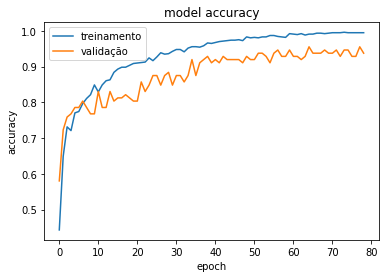

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


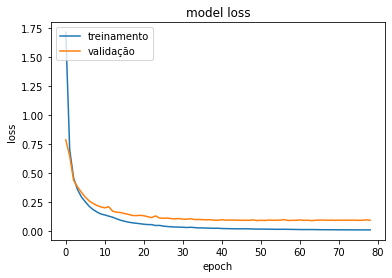

7/7 [==============================] - 1s 174ms/step


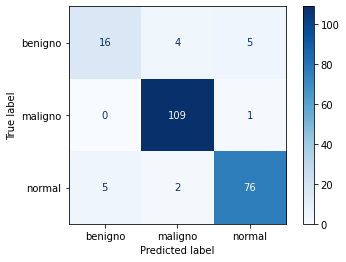

accuracy: 0.9220183486238532
              precision    recall  f1-score   support

     benigno       0.76      0.64      0.70        25
     maligno       0.95      0.99      0.97       110
      normal       0.93      0.92      0.92        83

    accuracy                           0.92       218
   macro avg       0.88      0.85      0.86       218
weighted avg       0.92      0.92      0.92       218

F1-score: 0.8619177280046846
specificity: 0.9580310880829016
sensitivity: 0.8488572471705002
AUC-ROC: 0.9608375319459657
\begin{tabular}{lrrrrr}
\hline
 Model   &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg     &   0.922018 &  0.861918 &      0.958031 &      0.848857 & 0.960838 \\
\hline
\end{tabular}


In [ ]:
run_full_model('vgg', imgs, balance_data = False, balance_type = None, data_augment = False)

[3.39393939 0.63276836 0.88888889]
Epoch 1/100
12/12 [==============================] - 16s 557ms/step - loss: 0.1641 - accuracy: 0.6793 - val_loss: 0.1130 - val_accuracy: 0.7946
Epoch 2/100
12/12 [==============================] - 4s 315ms/step - loss: 0.1072 - accuracy: 0.7940 - val_loss: 0.0802 - val_accuracy: 0.8393
Epoch 3/100
12/12 [==============================] - 4s 315ms/step - loss: 0.0839 - accuracy: 0.8449 - val_loss: 0.0722 - val_accuracy: 0.8393
Epoch 4/100
12/12 [==============================] - 4s 318ms/step - loss: 0.0713 - accuracy: 0.8553 - val_loss: 0.0618 - val_accuracy: 0.8571
Epoch 5/100
12/12 [==============================] - 4s 320ms/step - loss: 0.0661 - accuracy: 0.8722 - val_loss: 0.0581 - val_accuracy: 0.8482
Epoch 6/100
12/12 [==============================] - 4s 320ms/step - loss: 0.0581 - accuracy: 0.8970 - val_loss: 0.0594 - val_accuracy: 0.8661
Epoch 7/100
12/12 [==============================] - 4s 320ms/step - loss: 0.0527 - accuracy: 0.9035 - val

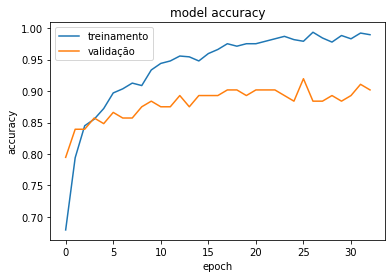

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


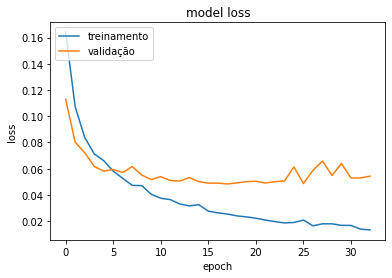

7/7 [==============================] - 6s 560ms/step


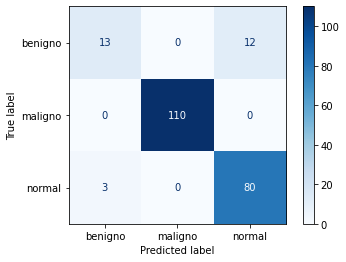

accuracy: 0.9311926605504587
              precision    recall  f1-score   support

     benigno       0.81      0.52      0.63        25
     maligno       1.00      1.00      1.00       110
      normal       0.87      0.96      0.91        83

    accuracy                           0.93       218
   macro avg       0.89      0.83      0.85       218
weighted avg       0.93      0.93      0.93       218

F1-score: 0.8494773519163763
specificity: 0.9651890232201112
sensitivity: 0.8279518072289157
AUC-ROC: 0.9746849215041986
\begin{tabular}{lrrrrr}
\hline
 Model    &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg      &   0.922018 &  0.861918 &      0.958031 &      0.848857 & 0.960838 \\
 densenet &   0.931193 &  0.849477 &      0.965189 &      0.827952 & 0.974685 \\
\hline
\end{tabular}


In [ ]:
run_full_model('densenet', imgs, balance_data = False, balance_type = None, data_augment = False)

87910968/87910968 [==============================] - 6s 0us/step
[3.39393939 0.63276836 0.88888889]
Epoch 1/100
12/12 [==============================] - 18s 938ms/step - loss: 0.1987 - accuracy: 0.5671 - val_loss: 0.1374 - val_accuracy: 0.7054
Epoch 2/100
12/12 [==============================] - 3s 261ms/step - loss: 0.1075 - accuracy: 0.7718 - val_loss: 0.0988 - val_accuracy: 0.7857
Epoch 3/100
12/12 [==============================] - 3s 263ms/step - loss: 0.0848 - accuracy: 0.8240 - val_loss: 0.0923 - val_accuracy: 0.7857
Epoch 4/100
12/12 [==============================] - 3s 263ms/step - loss: 0.0714 - accuracy: 0.8579 - val_loss: 0.0870 - val_accuracy: 0.7946
Epoch 5/100
12/12 [==============================] - 3s 264ms/step - loss: 0.0671 - accuracy: 0.8657 - val_loss: 0.0808 - val_accuracy: 0.8214
Epoch 6/100
12/12 [==============================] - 3s 265ms/step - loss: 0.0581 - accuracy: 0.8840 - val_loss: 0.0704 - val_accuracy: 0.8661
Epoch 7/100
12/12 [======================

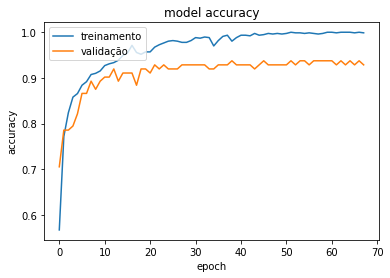

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


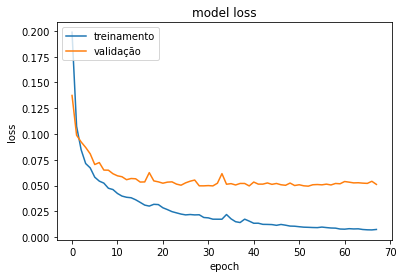

7/7 [==============================] - 4s 415ms/step


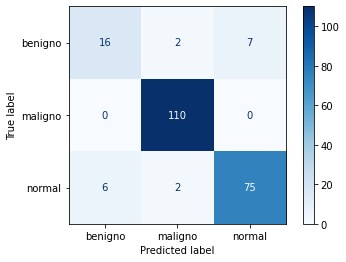

accuracy: 0.9220183486238532
              precision    recall  f1-score   support

     benigno       0.73      0.64      0.68        25
     maligno       0.96      1.00      0.98       110
      normal       0.91      0.90      0.91        83

    accuracy                           0.92       218
   macro avg       0.87      0.85      0.86       218
weighted avg       0.92      0.92      0.92       218

F1-score: 0.8573616100211846
specificity: 0.9600076760698523
sensitivity: 0.8478714859437751
AUC-ROC: 0.9682015334063528
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.922018 &  0.861918 &      0.958031 &      0.848857 & 0.960838 \\
 densenet  &   0.931193 &  0.849477 &      0.965189 &      0.827952 & 0.974685 \\
 inception &   0.922018 &  0.857362 &      0.960008 &      0.847871 & 0.968202 \\
\hline
\end{tabular}


In [ ]:
run_full_model('inception', imgs, balance_data = False, balance_type = None, data_augment = False)

83683744/83683744 [==============================] - 5s 0us/step
[3.39393939 0.63276836 0.88888889]
Epoch 1/100
12/12 [==============================] - 16s 1s/step - loss: 0.1196 - accuracy: 0.7510 - val_loss: 0.0848 - val_accuracy: 0.7857
Epoch 2/100
12/12 [==============================] - 7s 561ms/step - loss: 0.0703 - accuracy: 0.8722 - val_loss: 0.0711 - val_accuracy: 0.8214
Epoch 3/100
12/12 [==============================] - 7s 573ms/step - loss: 0.0578 - accuracy: 0.9035 - val_loss: 0.0631 - val_accuracy: 0.8839
Epoch 4/100
12/12 [==============================] - 7s 580ms/step - loss: 0.0551 - accuracy: 0.8983 - val_loss: 0.0598 - val_accuracy: 0.8839
Epoch 5/100
12/12 [==============================] - 7s 584ms/step - loss: 0.0506 - accuracy: 0.9022 - val_loss: 0.0528 - val_accuracy: 0.8839
Epoch 6/100
12/12 [==============================] - 7s 579ms/step - loss: 0.0451 - accuracy: 0.9126 - val_loss: 0.0519 - val_accuracy: 0.8839
Epoch 7/100
12/12 [=========================

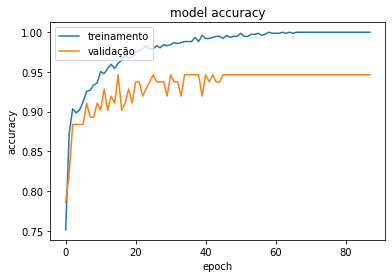

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


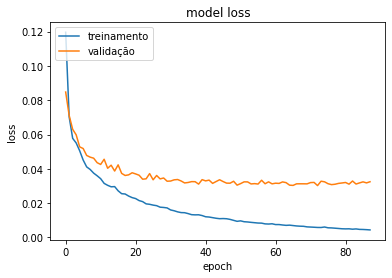

7/7 [==============================] - 3s 442ms/step


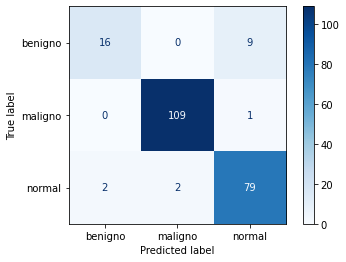

accuracy: 0.9357798165137615
              precision    recall  f1-score   support

     benigno       0.89      0.64      0.74        25
     maligno       0.98      0.99      0.99       110
      normal       0.89      0.95      0.92        83

    accuracy                           0.94       218
   macro avg       0.92      0.86      0.88       218
weighted avg       0.94      0.94      0.93       218

F1-score: 0.8830720123469781
specificity: 0.9656815710356298
sensitivity: 0.8609054399415844
AUC-ROC: 0.9833961299744433
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.922018 &  0.861918 &      0.958031 &      0.848857 & 0.960838 \\
 densenet  &   0.931193 &  0.849477 &      0.965189 &      0.827952 & 0.974685 \\
 inception &   0.922018 &  0.857362 &      0.960008 &      0.847871 & 0.968202 \\
 xception  &   0.93578  &  0.883072 &      0.965682 &      0.860905 & 0.983396 \\
\hline
\end{tabular}


In [ ]:
run_full_model('xception', imgs, balance_data = False, balance_type = None, data_augment = False)

categorical cross entropy

[3.39393939 0.63276836 0.88888889]
Epoch 1/100
12/12 [==============================] - 6s 423ms/step - loss: 2.9374 - accuracy: 0.3820 - val_loss: 1.6994 - val_accuracy: 0.6161
Epoch 2/100
12/12 [==============================] - 5s 408ms/step - loss: 1.4643 - accuracy: 0.6584 - val_loss: 1.3268 - val_accuracy: 0.6786
Epoch 3/100
12/12 [==============================] - 5s 411ms/step - loss: 1.0255 - accuracy: 0.7366 - val_loss: 0.9575 - val_accuracy: 0.6518
Epoch 4/100
12/12 [==============================] - 5s 414ms/step - loss: 0.7730 - accuracy: 0.7210 - val_loss: 0.8118 - val_accuracy: 0.7232
Epoch 5/100
12/12 [==============================] - 5s 418ms/step - loss: 0.6327 - accuracy: 0.7849 - val_loss: 0.7016 - val_accuracy: 0.7768
Epoch 6/100
12/12 [==============================] - 5s 420ms/step - loss: 0.5354 - accuracy: 0.7992 - val_loss: 0.6391 - val_accuracy: 0.7946
Epoch 7/100
12/12 [==============================] - 5s 421ms/step - loss: 0.4690 - accuracy: 0.8279 - val_

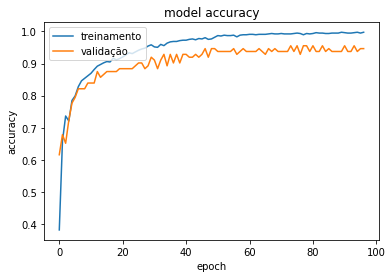

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


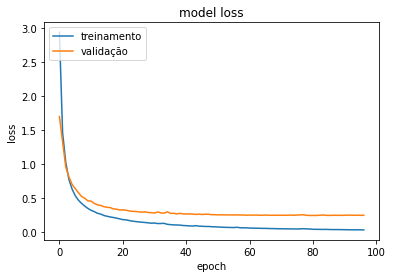

7/7 [==============================] - 1s 174ms/step


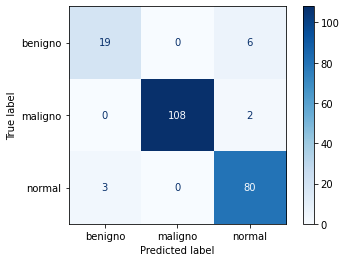

accuracy: 0.9495412844036697
              precision    recall  f1-score   support

     benigno       0.86      0.76      0.81        25
     maligno       1.00      0.98      0.99       110
      normal       0.91      0.96      0.94        83

    accuracy                           0.95       218
   macro avg       0.92      0.90      0.91       218
weighted avg       0.95      0.95      0.95       218

F1-score: 0.9116696136637166
specificity: 0.9750655664299878
sensitivity: 0.9018912011683096
AUC-ROC: 0.9710894487039066
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.949541 &  0.91167  &      0.975066 &      0.901891 & 0.971089 \\
 densenet  &   0.931193 &  0.849477 &      0.965189 &      0.827952 & 0.974685 \\
 inception &   0.922018 &  0.857362 &      0.960008 &      0.847871 & 0.968202 \\
 xception  &   0.93578  &  0.883072 &      0.965682 &      0.860905 & 0.983396 \\
\hline
\end{tabular}


In [ ]:
run_full_model('vgg', imgs, balance_data = False, balance_type = None, data_augment = False, loss = tf.keras.losses.CategoricalCrossentropy())

[3.39393939 0.63276836 0.88888889]
Epoch 1/100
12/12 [==============================] - 15s 566ms/step - loss: 1.0551 - accuracy: 0.5554 - val_loss: 0.7606 - val_accuracy: 0.7500
Epoch 2/100
12/12 [==============================] - 4s 317ms/step - loss: 0.6120 - accuracy: 0.8083 - val_loss: 0.5601 - val_accuracy: 0.8125
Epoch 3/100
12/12 [==============================] - 4s 316ms/step - loss: 0.4904 - accuracy: 0.8370 - val_loss: 0.4927 - val_accuracy: 0.8214
Epoch 4/100
12/12 [==============================] - 4s 318ms/step - loss: 0.4137 - accuracy: 0.8618 - val_loss: 0.4337 - val_accuracy: 0.8214
Epoch 5/100
12/12 [==============================] - 4s 318ms/step - loss: 0.3691 - accuracy: 0.8748 - val_loss: 0.4027 - val_accuracy: 0.8304
Epoch 6/100
12/12 [==============================] - 4s 321ms/step - loss: 0.3329 - accuracy: 0.8866 - val_loss: 0.3744 - val_accuracy: 0.8393
Epoch 7/100
12/12 [==============================] - 4s 320ms/step - loss: 0.3089 - accuracy: 0.8931 - val

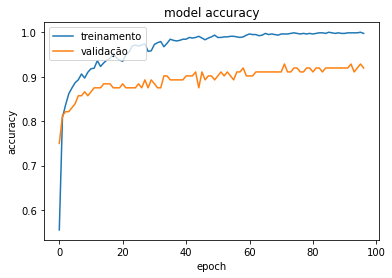

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


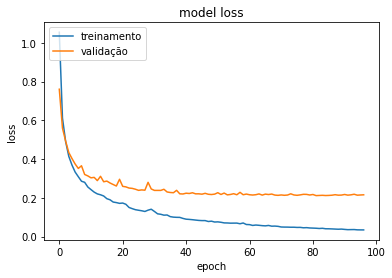

7/7 [==============================] - 3s 146ms/step


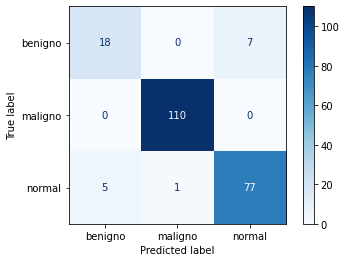

accuracy: 0.9403669724770642
              precision    recall  f1-score   support

     benigno       0.78      0.72      0.75        25
     maligno       0.99      1.00      1.00       110
      normal       0.92      0.93      0.92        83

    accuracy                           0.94       218
   macro avg       0.90      0.88      0.89       218
weighted avg       0.94      0.94      0.94       218

F1-score: 0.8892102672483088
specificity: 0.9709940510458646
sensitivity: 0.8825702811244979
AUC-ROC: 0.9843745892661556
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.949541 &  0.91167  &      0.975066 &      0.901891 & 0.971089 \\
 densenet  &   0.940367 &  0.88921  &      0.970994 &      0.88257  & 0.984375 \\
 inception &   0.922018 &  0.857362 &      0.960008 &      0.847871 & 0.968202 \\
 xception  &   0.93578  &  0.883072 &      0.965682 &      0.860905 & 0.983396 \\
\hline
\end{tabular}


In [ ]:
run_full_model('densenet', imgs, balance_data = False, balance_type = None, data_augment = False, loss = tf.keras.losses.CategoricalCrossentropy())

[3.39393939 0.63276836 0.88888889]
Epoch 1/100
12/12 [==============================] - 8s 369ms/step - loss: 0.9040 - accuracy: 0.6219 - val_loss: 0.6053 - val_accuracy: 0.8214
Epoch 2/100
12/12 [==============================] - 3s 262ms/step - loss: 0.5086 - accuracy: 0.8253 - val_loss: 0.4856 - val_accuracy: 0.7946
Epoch 3/100
12/12 [==============================] - 3s 262ms/step - loss: 0.4037 - accuracy: 0.8514 - val_loss: 0.4149 - val_accuracy: 0.8125
Epoch 4/100
12/12 [==============================] - 3s 261ms/step - loss: 0.3609 - accuracy: 0.8709 - val_loss: 0.3644 - val_accuracy: 0.8750
Epoch 5/100
12/12 [==============================] - 3s 264ms/step - loss: 0.3240 - accuracy: 0.8866 - val_loss: 0.3369 - val_accuracy: 0.8750
Epoch 6/100
12/12 [==============================] - 3s 262ms/step - loss: 0.2980 - accuracy: 0.8931 - val_loss: 0.3200 - val_accuracy: 0.8750
Epoch 7/100
12/12 [==============================] - 3s 262ms/step - loss: 0.2810 - accuracy: 0.8944 - val_

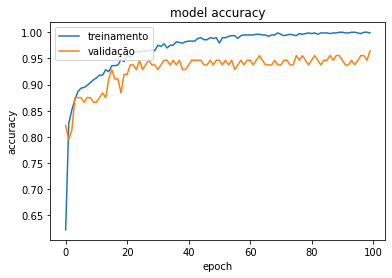

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


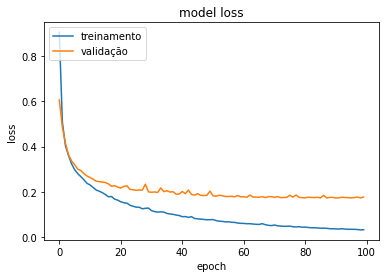

7/7 [==============================] - 2s 113ms/step


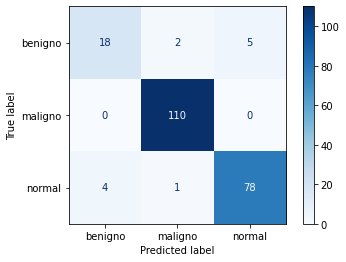

accuracy: 0.944954128440367
              precision    recall  f1-score   support

     benigno       0.82      0.72      0.77        25
     maligno       0.97      1.00      0.99       110
      normal       0.94      0.94      0.94        83

    accuracy                           0.94       218
   macro avg       0.91      0.89      0.90       218
weighted avg       0.94      0.94      0.94       218

F1-score: 0.897421189384961
specificity: 0.9714865988613829
sensitivity: 0.886586345381526
AUC-ROC: 0.9735370573201898
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.949541 &  0.91167  &      0.975066 &      0.901891 & 0.971089 \\
 densenet  &   0.940367 &  0.88921  &      0.970994 &      0.88257  & 0.984375 \\
 inception &   0.944954 &  0.897421 &      0.971487 &      0.886586 & 0.973537 \\
 xception  &   0.93578  &  0.883072 &      0.965682 &      0.860905 & 0.983396 \\
\hline
\end{tabular}


In [ ]:
run_full_model('inception', imgs, balance_data = False, balance_type = None, data_augment = False, loss = tf.keras.losses.CategoricalCrossentropy())

[3.39393939 0.63276836 0.88888889]
Epoch 1/100
12/12 [==============================] - 9s 614ms/step - loss: 0.7591 - accuracy: 0.7327 - val_loss: 0.5630 - val_accuracy: 0.8304
Epoch 2/100
12/12 [==============================] - 7s 554ms/step - loss: 0.4919 - accuracy: 0.8618 - val_loss: 0.4486 - val_accuracy: 0.8482
Epoch 3/100
12/12 [==============================] - 7s 565ms/step - loss: 0.3986 - accuracy: 0.8696 - val_loss: 0.3989 - val_accuracy: 0.8393
Epoch 4/100
12/12 [==============================] - 7s 573ms/step - loss: 0.3490 - accuracy: 0.8814 - val_loss: 0.3659 - val_accuracy: 0.8750
Epoch 5/100
12/12 [==============================] - 7s 582ms/step - loss: 0.3238 - accuracy: 0.8879 - val_loss: 0.3463 - val_accuracy: 0.8482
Epoch 6/100
12/12 [==============================] - 7s 583ms/step - loss: 0.2971 - accuracy: 0.8918 - val_loss: 0.3277 - val_accuracy: 0.8661
Epoch 7/100
12/12 [==============================] - 7s 579ms/step - loss: 0.2788 - accuracy: 0.9074 - val_

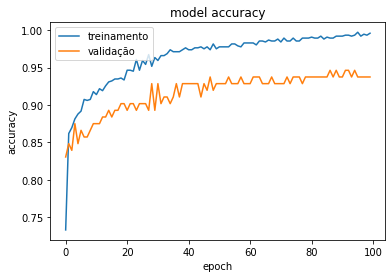

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


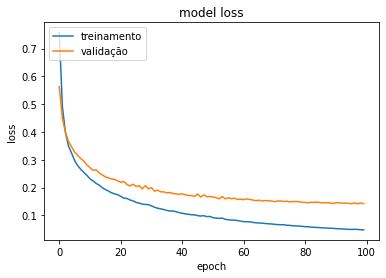

7/7 [==============================] - 2s 236ms/step


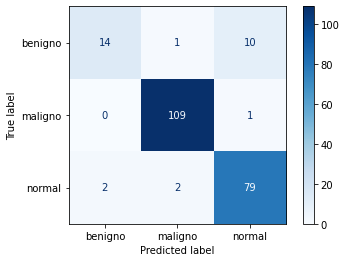

accuracy: 0.926605504587156
              precision    recall  f1-score   support

     benigno       0.88      0.56      0.68        25
     maligno       0.97      0.99      0.98       110
      normal       0.88      0.95      0.91        83

    accuracy                           0.93       218
   macro avg       0.91      0.83      0.86       218
weighted avg       0.93      0.93      0.92       218

F1-score: 0.8594012029793786
specificity: 0.9601260154800743
sensitivity: 0.8342387732749179
AUC-ROC: 0.9784826579043447
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.949541 &  0.91167  &      0.975066 &      0.901891 & 0.971089 \\
 densenet  &   0.940367 &  0.88921  &      0.970994 &      0.88257  & 0.984375 \\
 inception &   0.944954 &  0.897421 &      0.971487 &      0.886586 & 0.973537 \\
 xception  &   0.926606 &  0.859401 &      0.960126 &      0.834239 & 0.978483 \\
\hline
\end{tabular}


In [ ]:
run_full_model('xception', imgs, balance_data = False, balance_type = None, data_augment = False, loss = tf.keras.losses.CategoricalCrossentropy())

## Model com balanceamento de classes SMOTE

80134624/80134624 [==============================] - 0s 0us/step
[3.39393939 0.63276836 0.88888889]
Epoch 1/100
19/19 [==============================] - 24s 705ms/step - loss: 2.0269 - accuracy: 0.3759 - val_loss: 1.2703 - val_accuracy: 0.4911
Epoch 2/100
19/19 [==============================] - 7s 366ms/step - loss: 1.0370 - accuracy: 0.5689 - val_loss: 0.7720 - val_accuracy: 0.6339
Epoch 3/100
19/19 [==============================] - 7s 365ms/step - loss: 0.7248 - accuracy: 0.6905 - val_loss: 0.4781 - val_accuracy: 0.7946
Epoch 4/100
19/19 [==============================] - 7s 369ms/step - loss: 0.5584 - accuracy: 0.7687 - val_loss: 0.3874 - val_accuracy: 0.8571
Epoch 5/100
19/19 [==============================] - 7s 371ms/step - loss: 0.4455 - accuracy: 0.8189 - val_loss: 0.3463 - val_accuracy: 0.8661
Epoch 6/100
19/19 [==============================] - 7s 375ms/step - loss: 0.3826 - accuracy: 0.8546 - val_loss: 0.3409 - val_accuracy: 0.8750
Epoch 7/100
19/19 [======================

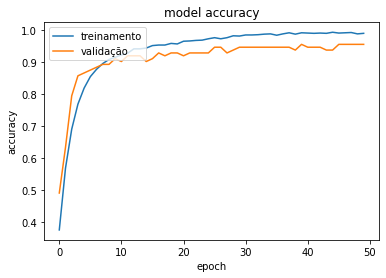

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


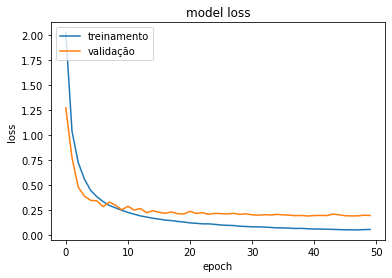

7/7 [==============================] - 4s 596ms/step


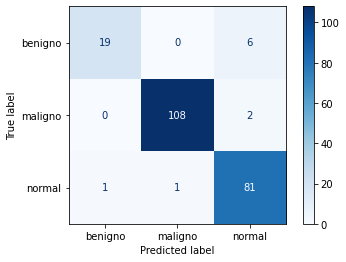

accuracy: 0.9541284403669725
              precision    recall  f1-score   support

     benigno       0.95      0.76      0.84        25
     maligno       0.99      0.98      0.99       110
      normal       0.91      0.98      0.94        83

    accuracy                           0.95       218
   macro avg       0.95      0.91      0.92       218
weighted avg       0.96      0.95      0.95       218

F1-score: 0.9242020931412457
specificity: 0.9754333781104075
sensitivity: 0.9059072654253377
AUC-ROC: 0.9761248630887184
\begin{tabular}{lrrrrr}
\hline
 Model   &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg     &   0.954128 &  0.924202 &      0.975433 &      0.905907 & 0.976125 \\
\hline
\end{tabular}


In [ ]:
run_full_model('vgg', imgs, balance_data = True, balance_type = 'smote', data_augment = False, loss = tf.keras.losses.CategoricalCrossentropy())

74836368/74836368 [==============================] - 0s 0us/step
[3.39393939 0.63276836 0.88888889]
Epoch 1/100
19/19 [==============================] - 29s 839ms/step - loss: 1.0254 - accuracy: 0.4974 - val_loss: 0.7365 - val_accuracy: 0.6875
Epoch 2/100
19/19 [==============================] - 6s 297ms/step - loss: 0.6838 - accuracy: 0.7355 - val_loss: 0.5534 - val_accuracy: 0.7768
Epoch 3/100
19/19 [==============================] - 6s 300ms/step - loss: 0.5513 - accuracy: 0.7900 - val_loss: 0.4854 - val_accuracy: 0.7589
Epoch 4/100
19/19 [==============================] - 6s 300ms/step - loss: 0.4572 - accuracy: 0.8308 - val_loss: 0.4710 - val_accuracy: 0.7768
Epoch 5/100
19/19 [==============================] - 6s 303ms/step - loss: 0.4129 - accuracy: 0.8546 - val_loss: 0.4998 - val_accuracy: 0.7857
Epoch 6/100
19/19 [==============================] - 6s 300ms/step - loss: 0.3643 - accuracy: 0.8750 - val_loss: 0.3947 - val_accuracy: 0.8125
Epoch 7/100
19/19 [======================

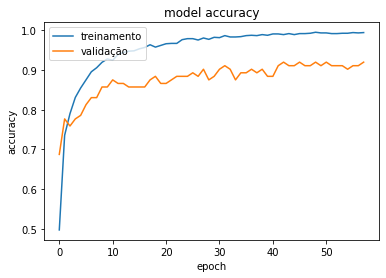

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


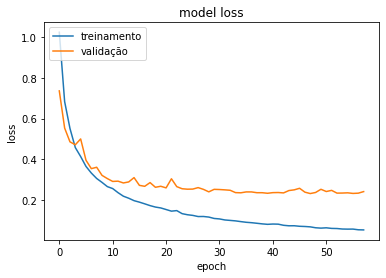

7/7 [==============================] - 6s 568ms/step


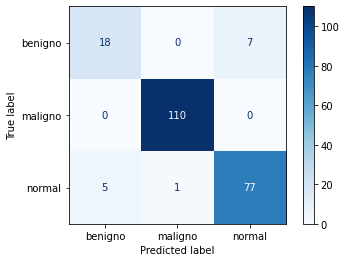

accuracy: 0.9403669724770642
              precision    recall  f1-score   support

     benigno       0.78      0.72      0.75        25
     maligno       0.99      1.00      1.00       110
      normal       0.92      0.93      0.92        83

    accuracy                           0.94       218
   macro avg       0.90      0.88      0.89       218
weighted avg       0.94      0.94      0.94       218

F1-score: 0.8892102672483088
specificity: 0.9709940510458646
sensitivity: 0.8825702811244979
AUC-ROC: 0.9815465498357065
\begin{tabular}{lrrrrr}
\hline
 Model    &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg      &   0.954128 &  0.924202 &      0.975433 &      0.905907 & 0.976125 \\
 densenet &   0.940367 &  0.88921  &      0.970994 &      0.88257  & 0.981547 \\
\hline
\end{tabular}


In [ ]:
run_full_model('densenet', imgs, balance_data = True, balance_type = 'smote', data_augment = False, loss = tf.keras.losses.CategoricalCrossentropy())

87910968/87910968 [==============================] - 0s 0us/step
[3.39393939 0.63276836 0.88888889]
Epoch 1/100
19/19 [==============================] - 17s 575ms/step - loss: 0.9515 - accuracy: 0.5349 - val_loss: 0.6506 - val_accuracy: 0.7679
Epoch 2/100
19/19 [==============================] - 5s 242ms/step - loss: 0.6360 - accuracy: 0.7543 - val_loss: 0.4869 - val_accuracy: 0.8304
Epoch 3/100
19/19 [==============================] - 5s 243ms/step - loss: 0.5100 - accuracy: 0.8291 - val_loss: 0.4743 - val_accuracy: 0.8214
Epoch 4/100
19/19 [==============================] - 5s 244ms/step - loss: 0.4361 - accuracy: 0.8512 - val_loss: 0.3942 - val_accuracy: 0.8661
Epoch 5/100
19/19 [==============================] - 5s 248ms/step - loss: 0.3911 - accuracy: 0.8861 - val_loss: 0.3776 - val_accuracy: 0.8482
Epoch 6/100
19/19 [==============================] - 5s 246ms/step - loss: 0.3443 - accuracy: 0.9056 - val_loss: 0.3541 - val_accuracy: 0.8750
Epoch 7/100
19/19 [======================

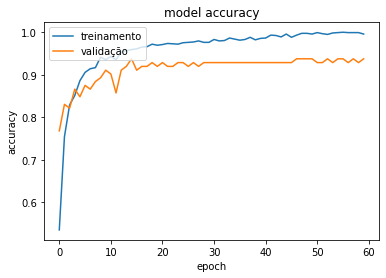

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


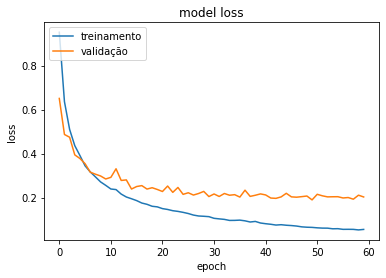

7/7 [==============================] - 4s 423ms/step


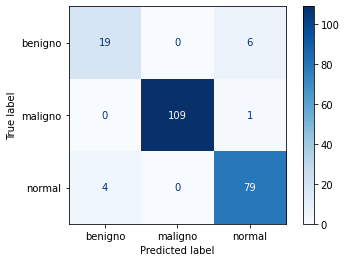

accuracy: 0.9495412844036697
              precision    recall  f1-score   support

     benigno       0.83      0.76      0.79        25
     maligno       1.00      0.99      1.00       110
      normal       0.92      0.95      0.93        83

    accuracy                           0.95       218
   macro avg       0.91      0.90      0.91       218
weighted avg       0.95      0.95      0.95       218

F1-score: 0.9073372330748516
specificity: 0.975807586515704
sensitivity: 0.9009054399415845
AUC-ROC: 0.9728002920774005
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.954128 &  0.924202 &      0.975433 &      0.905907 & 0.976125 \\
 densenet  &   0.940367 &  0.88921  &      0.970994 &      0.88257  & 0.981547 \\
 inception &   0.949541 &  0.907337 &      0.975808 &      0.900905 & 0.9728   \\
\hline
\end{tabular}


In [ ]:
run_full_model('inception', imgs, balance_data = True, balance_type = 'smote', data_augment = False, loss = tf.keras.losses.CategoricalCrossentropy())

83683744/83683744 [==============================] - 0s 0us/step
[3.39393939 0.63276836 0.88888889]
Epoch 1/100
19/19 [==============================] - 19s 732ms/step - loss: 0.8448 - accuracy: 0.6420 - val_loss: 0.5595 - val_accuracy: 0.8304
Epoch 2/100
19/19 [==============================] - 10s 549ms/step - loss: 0.5821 - accuracy: 0.7840 - val_loss: 0.4910 - val_accuracy: 0.8036
Epoch 3/100
19/19 [==============================] - 11s 559ms/step - loss: 0.4784 - accuracy: 0.8325 - val_loss: 0.4213 - val_accuracy: 0.8750
Epoch 4/100
19/19 [==============================] - 11s 555ms/step - loss: 0.4217 - accuracy: 0.8665 - val_loss: 0.3832 - val_accuracy: 0.8750
Epoch 5/100
19/19 [==============================] - 10s 546ms/step - loss: 0.3804 - accuracy: 0.8954 - val_loss: 0.3491 - val_accuracy: 0.8661
Epoch 6/100
19/19 [==============================] - 10s 541ms/step - loss: 0.3526 - accuracy: 0.8929 - val_loss: 0.3238 - val_accuracy: 0.8839
Epoch 7/100
19/19 [=================

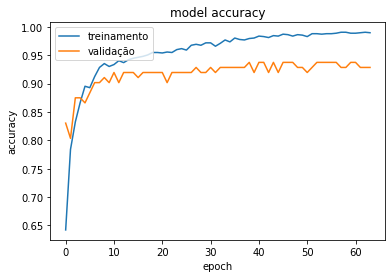

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


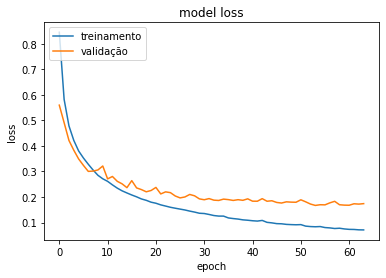

7/7 [==============================] - 3s 460ms/step


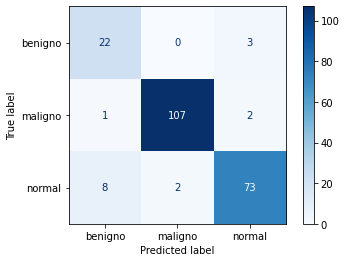

accuracy: 0.926605504587156
              precision    recall  f1-score   support

     benigno       0.71      0.88      0.79        25
     maligno       0.98      0.97      0.98       110
      normal       0.94      0.88      0.91        83

    accuracy                           0.93       218
   macro avg       0.88      0.91      0.89       218
weighted avg       0.93      0.93      0.93       218

F1-score: 0.889905177874207
specificity: 0.9659374400307043
sensitivity: 0.9107484483388099
AUC-ROC: 0.9781489594742606
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.954128 &  0.924202 &      0.975433 &      0.905907 & 0.976125 \\
 densenet  &   0.940367 &  0.88921  &      0.970994 &      0.88257  & 0.981547 \\
 inception &   0.949541 &  0.907337 &      0.975808 &      0.900905 & 0.9728   \\
 xception  &   0.926606 &  0.889905 &      0.965937 &      0.910748 & 0.978149 \\
\hline
\end{tabular}


In [ ]:
run_full_model('xception', imgs, balance_data = True, balance_type = 'smote', data_augment = False, loss = tf.keras.losses.CategoricalCrossentropy())

## Model com balanceamento de classes Oversampling

[3.39393939 0.63276836 0.88888889]
Epoch 1/100
19/19 [==============================] - 8s 409ms/step - loss: 2.1894 - accuracy: 0.3580 - val_loss: 1.0048 - val_accuracy: 0.5714
Epoch 2/100
19/19 [==============================] - 7s 388ms/step - loss: 1.1069 - accuracy: 0.5808 - val_loss: 0.7598 - val_accuracy: 0.6786
Epoch 3/100
19/19 [==============================] - 8s 395ms/step - loss: 0.7870 - accuracy: 0.6726 - val_loss: 0.5638 - val_accuracy: 0.7679
Epoch 4/100
19/19 [==============================] - 8s 399ms/step - loss: 0.6341 - accuracy: 0.7279 - val_loss: 0.5831 - val_accuracy: 0.7054
Epoch 5/100
19/19 [==============================] - 8s 404ms/step - loss: 0.5062 - accuracy: 0.7806 - val_loss: 0.5173 - val_accuracy: 0.7411
Epoch 6/100
19/19 [==============================] - 8s 400ms/step - loss: 0.4252 - accuracy: 0.8214 - val_loss: 0.4352 - val_accuracy: 0.7768
Epoch 7/100
19/19 [==============================] - 8s 394ms/step - loss: 0.3714 - accuracy: 0.8461 - val_

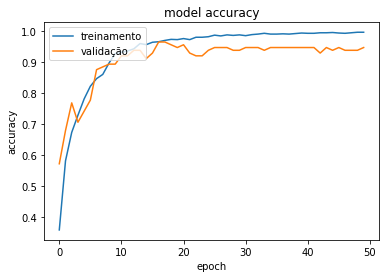

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


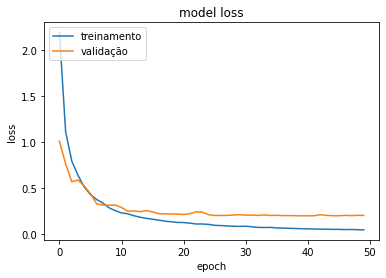

7/7 [==============================] - 1s 182ms/step


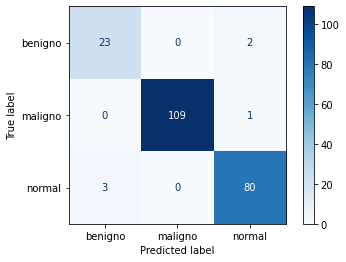

accuracy: 0.9724770642201835
              precision    recall  f1-score   support

     benigno       0.88      0.92      0.90        25
     maligno       1.00      0.99      1.00       110
      normal       0.96      0.96      0.96        83

    accuracy                           0.97       218
   macro avg       0.95      0.96      0.95       218
weighted avg       0.97      0.97      0.97       218

F1-score: 0.9537499986516035
specificity: 0.9874112454423335
sensitivity: 0.9582548375319461
AUC-ROC: 0.9798050383351589
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.972477 &  0.95375  &      0.987411 &      0.958255 & 0.979805 \\
 densenet  &   0.940367 &  0.88921  &      0.970994 &      0.88257  & 0.981547 \\
 inception &   0.949541 &  0.907337 &      0.975808 &      0.900905 & 0.9728   \\
 xception  &   0.926606 &  0.889905 &      0.965937 &      0.910748 & 0.978149 \\
\hline
\end{tabular}


In [ ]:
run_full_model('vgg', imgs, balance_data = True, balance_type = 'oversample', data_augment = False, loss = tf.keras.losses.CategoricalCrossentropy())

[3.39393939 0.63276836 0.88888889]
Epoch 1/100
19/19 [==============================] - 17s 447ms/step - loss: 1.0415 - accuracy: 0.4898 - val_loss: 0.8280 - val_accuracy: 0.6339
Epoch 2/100
19/19 [==============================] - 6s 292ms/step - loss: 0.6573 - accuracy: 0.7007 - val_loss: 0.6036 - val_accuracy: 0.7411
Epoch 3/100
19/19 [==============================] - 6s 295ms/step - loss: 0.5289 - accuracy: 0.7832 - val_loss: 0.4793 - val_accuracy: 0.7946
Epoch 4/100
19/19 [==============================] - 6s 296ms/step - loss: 0.4554 - accuracy: 0.8384 - val_loss: 0.4474 - val_accuracy: 0.8036
Epoch 5/100
19/19 [==============================] - 6s 299ms/step - loss: 0.4005 - accuracy: 0.8741 - val_loss: 0.3722 - val_accuracy: 0.8304
Epoch 6/100
19/19 [==============================] - 6s 301ms/step - loss: 0.3619 - accuracy: 0.8861 - val_loss: 0.3736 - val_accuracy: 0.8304
Epoch 7/100
19/19 [==============================] - 6s 302ms/step - loss: 0.3254 - accuracy: 0.9201 - val

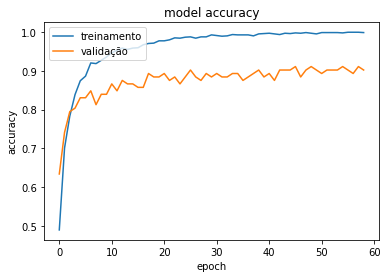

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


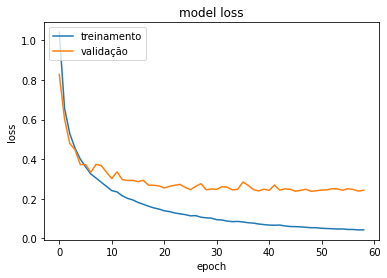

7/7 [==============================] - 4s 147ms/step


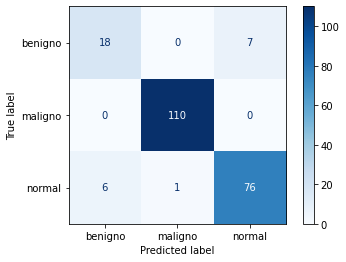

accuracy: 0.9357798165137615
              precision    recall  f1-score   support

     benigno       0.75      0.72      0.73        25
     maligno       0.99      1.00      1.00       110
      normal       0.92      0.92      0.92        83

    accuracy                           0.94       218
   macro avg       0.89      0.88      0.88       218
weighted avg       0.93      0.94      0.94       218

F1-score: 0.8819438804252006
specificity: 0.9692669353291116
sensitivity: 0.8785542168674699
AUC-ROC: 0.981648046732384
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.972477 &  0.95375  &      0.987411 &      0.958255 & 0.979805 \\
 densenet  &   0.93578  &  0.881944 &      0.969267 &      0.878554 & 0.981648 \\
 inception &   0.949541 &  0.907337 &      0.975808 &      0.900905 & 0.9728   \\
 xception  &   0.926606 &  0.889905 &      0.965937 &      0.910748 & 0.978149 \\
\hline
\end{tabular}


In [ ]:
run_full_model('densenet', imgs, balance_data = True, balance_type = 'oversample', data_augment = False, loss = tf.keras.losses.CategoricalCrossentropy())

[3.39393939 0.63276836 0.88888889]
Epoch 1/100
19/19 [==============================] - 9s 303ms/step - loss: 0.9908 - accuracy: 0.5434 - val_loss: 0.6421 - val_accuracy: 0.7500
Epoch 2/100
19/19 [==============================] - 5s 237ms/step - loss: 0.6321 - accuracy: 0.7083 - val_loss: 0.4527 - val_accuracy: 0.8393
Epoch 3/100
19/19 [==============================] - 5s 240ms/step - loss: 0.5156 - accuracy: 0.7840 - val_loss: 0.5263 - val_accuracy: 0.6875
Epoch 4/100
19/19 [==============================] - 5s 240ms/step - loss: 0.4627 - accuracy: 0.8206 - val_loss: 0.4238 - val_accuracy: 0.8750
Epoch 5/100
19/19 [==============================] - 5s 242ms/step - loss: 0.4062 - accuracy: 0.8690 - val_loss: 0.4191 - val_accuracy: 0.7946
Epoch 6/100
19/19 [==============================] - 5s 245ms/step - loss: 0.3695 - accuracy: 0.8852 - val_loss: 0.3640 - val_accuracy: 0.8750
Epoch 7/100
19/19 [==============================] - 5s 247ms/step - loss: 0.3380 - accuracy: 0.9031 - val_

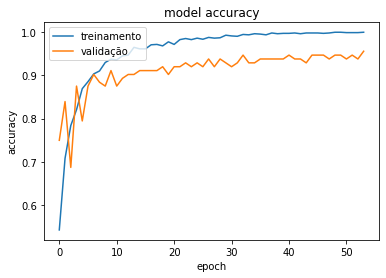

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


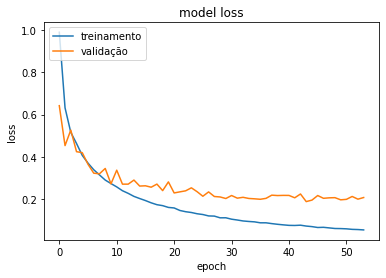

7/7 [==============================] - 2s 115ms/step


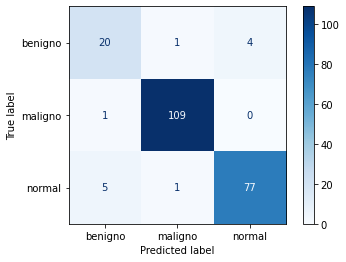

accuracy: 0.944954128440367
              precision    recall  f1-score   support

     benigno       0.77      0.80      0.78        25
     maligno       0.98      0.99      0.99       110
      normal       0.95      0.93      0.94        83

    accuracy                           0.94       218
   macro avg       0.90      0.91      0.90       218
weighted avg       0.95      0.94      0.95       218

F1-score: 0.9032544850335381
specificity: 0.9735879229834324
sensitivity: 0.9062066447608617
AUC-ROC: 0.9719693318729462
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.972477 &  0.95375  &      0.987411 &      0.958255 & 0.979805 \\
 densenet  &   0.93578  &  0.881944 &      0.969267 &      0.878554 & 0.981648 \\
 inception &   0.944954 &  0.903254 &      0.973588 &      0.906207 & 0.971969 \\
 xception  &   0.926606 &  0.889905 &      0.965937 &      0.910748 & 0.978149 \\
\hline
\end{tabular}


In [ ]:
run_full_model('inception', imgs, balance_data = True, balance_type = 'oversample', data_augment = False, loss = tf.keras.losses.CategoricalCrossentropy())

[3.39393939 0.63276836 0.88888889]
Epoch 1/100
19/19 [==============================] - 13s 568ms/step - loss: 0.8195 - accuracy: 0.6658 - val_loss: 0.5204 - val_accuracy: 0.7857
Epoch 2/100
19/19 [==============================] - 10s 539ms/step - loss: 0.5604 - accuracy: 0.7721 - val_loss: 0.4733 - val_accuracy: 0.8125
Epoch 3/100
19/19 [==============================] - 11s 551ms/step - loss: 0.4727 - accuracy: 0.8189 - val_loss: 0.4040 - val_accuracy: 0.8482
Epoch 4/100
19/19 [==============================] - 11s 561ms/step - loss: 0.4233 - accuracy: 0.8537 - val_loss: 0.3788 - val_accuracy: 0.8661
Epoch 5/100
19/19 [==============================] - 11s 552ms/step - loss: 0.3785 - accuracy: 0.8741 - val_loss: 0.3531 - val_accuracy: 0.8571
Epoch 6/100
19/19 [==============================] - 10s 541ms/step - loss: 0.3457 - accuracy: 0.8886 - val_loss: 0.3587 - val_accuracy: 0.8750
Epoch 7/100
19/19 [==============================] - 10s 535ms/step - loss: 0.3194 - accuracy: 0.9099

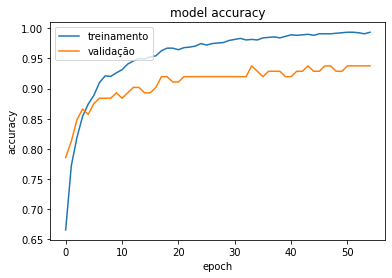

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


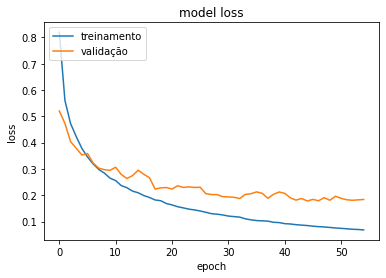

7/7 [==============================] - 2s 248ms/step


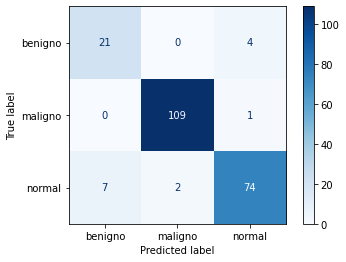

accuracy: 0.9357798165137615
              precision    recall  f1-score   support

     benigno       0.75      0.84      0.79        25
     maligno       0.98      0.99      0.99       110
      normal       0.94      0.89      0.91        83

    accuracy                           0.94       218
   macro avg       0.89      0.91      0.90       218
weighted avg       0.94      0.94      0.94       218

F1-score: 0.897486138822925
specificity: 0.9693916714642103
sensitivity: 0.9074917853231107
AUC-ROC: 0.9800898138006572
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.972477 &  0.95375  &      0.987411 &      0.958255 & 0.979805 \\
 densenet  &   0.93578  &  0.881944 &      0.969267 &      0.878554 & 0.981648 \\
 inception &   0.944954 &  0.903254 &      0.973588 &      0.906207 & 0.971969 \\
 xception  &   0.93578  &  0.897486 &      0.969392 &      0.907492 & 0.98009  \\
\hline
\end{tabular}


In [ ]:
run_full_model('xception', imgs, balance_data = True, balance_type = 'oversample', data_augment = False, loss = tf.keras.losses.CategoricalCrossentropy())

## Model com balanceamento e aumento de dados

80134624/80134624 [==============================] - 4s 0us/step
[3.39393939 0.63276836 0.88888889]
Epoch 1/100
19/19 [==============================] - 32s 1s/step - loss: 0.9353 - accuracy: 0.4209 - val_loss: 0.6179 - val_accuracy: 0.5179
Epoch 2/100
19/19 [==============================] - 15s 784ms/step - loss: 0.6226 - accuracy: 0.5077 - val_loss: 0.5388 - val_accuracy: 0.5000
Epoch 3/100
19/19 [==============================] - 15s 798ms/step - loss: 0.4813 - accuracy: 0.5604 - val_loss: 0.3127 - val_accuracy: 0.7143
Epoch 4/100
19/19 [==============================] - 15s 786ms/step - loss: 0.4061 - accuracy: 0.5893 - val_loss: 0.3587 - val_accuracy: 0.6339
Epoch 5/100
19/19 [==============================] - 15s 766ms/step - loss: 0.3329 - accuracy: 0.6395 - val_loss: 0.3873 - val_accuracy: 0.5893
Epoch 6/100
19/19 [==============================] - 15s 777ms/step - loss: 0.3135 - accuracy: 0.6582 - val_loss: 0.2897 - val_accuracy: 0.6875
Epoch 7/100
19/19 [====================

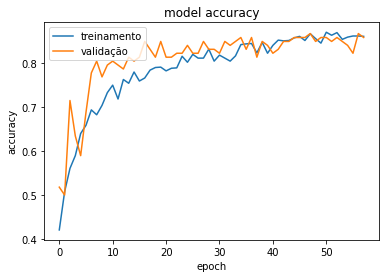

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


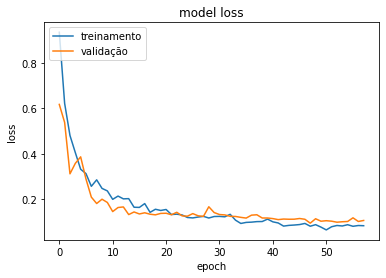

7/7 [==============================] - 4s 578ms/step


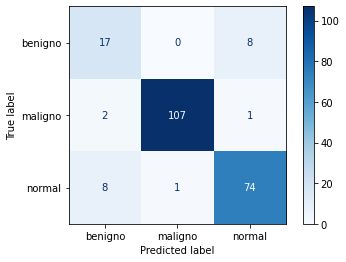

accuracy: 0.908256880733945
              precision    recall  f1-score   support

     benigno       0.63      0.68      0.65        25
     maligno       0.99      0.97      0.98       110
      normal       0.89      0.89      0.89        83

    accuracy                           0.91       218
   macro avg       0.84      0.85      0.84       218
weighted avg       0.91      0.91      0.91       218

F1-score: 0.8423545983510613
specificity: 0.9574202008571611
sensitivity: 0.8480978459291713
AUC-ROC: 0.9577108433734939
\begin{tabular}{lrrrrr}
\hline
 Model   &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg     &   0.908257 &  0.842355 &       0.95742 &      0.848098 & 0.957711 \\
\hline
\end{tabular}


In [ ]:
run_full_model('vgg', imgs, balance_data = True, balance_type = 'smote', data_augment = True)

74836368/74836368 [==============================] - 4s 0us/step
[3.39393939 0.63276836 0.88888889]
Epoch 1/100
19/19 [==============================] - 36s 1s/step - loss: 0.2317 - accuracy: 0.4745 - val_loss: 0.1308 - val_accuracy: 0.7143
Epoch 2/100
19/19 [==============================] - 15s 784ms/step - loss: 0.1647 - accuracy: 0.6029 - val_loss: 0.1179 - val_accuracy: 0.7589
Epoch 3/100
19/19 [==============================] - 15s 768ms/step - loss: 0.1362 - accuracy: 0.7075 - val_loss: 0.1234 - val_accuracy: 0.6786
Epoch 4/100
19/19 [==============================] - 15s 768ms/step - loss: 0.1215 - accuracy: 0.7389 - val_loss: 0.0947 - val_accuracy: 0.8304
Epoch 5/100
19/19 [==============================] - 15s 768ms/step - loss: 0.1117 - accuracy: 0.7696 - val_loss: 0.0853 - val_accuracy: 0.8482
Epoch 6/100
19/19 [==============================] - 15s 766ms/step - loss: 0.0996 - accuracy: 0.7857 - val_loss: 0.0768 - val_accuracy: 0.8393
Epoch 7/100
19/19 [====================

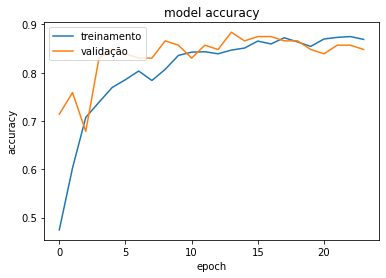

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


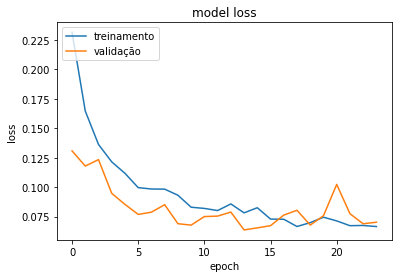

7/7 [==============================] - 6s 548ms/step


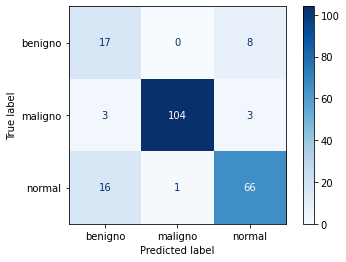

accuracy: 0.8577981651376146
              precision    recall  f1-score   support

     benigno       0.47      0.68      0.56        25
     maligno       0.99      0.95      0.97       110
      normal       0.86      0.80      0.82        83

    accuracy                           0.86       218
   macro avg       0.77      0.81      0.78       218
weighted avg       0.88      0.86      0.87       218

F1-score: 0.7832729698818147
specificity: 0.9369378878014456
sensitivity: 0.8068784227820373
AUC-ROC: 0.9246352683461118
\begin{tabular}{lrrrrr}
\hline
 Model    &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg      &   0.908257 &  0.842355 &      0.95742  &      0.848098 & 0.957711 \\
 densenet &   0.857798 &  0.783273 &      0.936938 &      0.806878 & 0.924635 \\
\hline
\end{tabular}


In [ ]:
run_full_model('densenet', imgs, balance_data = True, balance_type = 'smote', data_augment = True)

87910968/87910968 [==============================] - 5s 0us/step
[3.39393939 0.63276836 0.88888889]
Epoch 1/100
19/19 [==============================] - 35s 1s/step - loss: 0.2197 - accuracy: 0.4473 - val_loss: 0.1534 - val_accuracy: 0.6607
Epoch 2/100
19/19 [==============================] - 25s 1s/step - loss: 0.1482 - accuracy: 0.6420 - val_loss: 0.1336 - val_accuracy: 0.7054
Epoch 3/100
19/19 [==============================] - 24s 1s/step - loss: 0.1286 - accuracy: 0.6956 - val_loss: 0.1141 - val_accuracy: 0.7411
Epoch 4/100
19/19 [==============================] - 24s 1s/step - loss: 0.1176 - accuracy: 0.7406 - val_loss: 0.0873 - val_accuracy: 0.8125
Epoch 5/100
19/19 [==============================] - 25s 1s/step - loss: 0.1111 - accuracy: 0.7364 - val_loss: 0.0979 - val_accuracy: 0.7679
Epoch 6/100
19/19 [==============================] - 25s 1s/step - loss: 0.1063 - accuracy: 0.7568 - val_loss: 0.1016 - val_accuracy: 0.7589
Epoch 7/100
19/19 [==============================] - 2

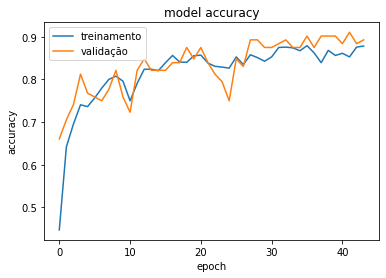

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


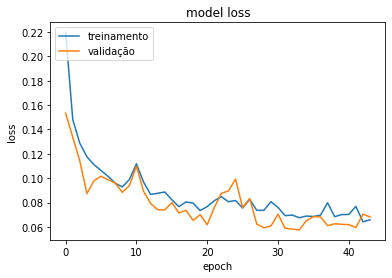

7/7 [==============================] - 3s 404ms/step


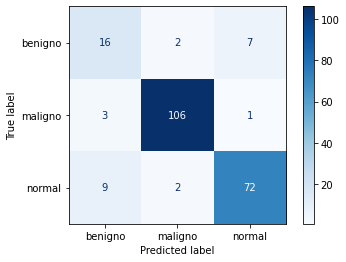

accuracy: 0.8899082568807339
              precision    recall  f1-score   support

     benigno       0.57      0.64      0.60        25
     maligno       0.96      0.96      0.96       110
      normal       0.90      0.87      0.88        83

    accuracy                           0.89       218
   macro avg       0.81      0.82      0.82       218
weighted avg       0.89      0.89      0.89       218

F1-score: 0.8169485104547034
specificity: 0.947175845966865
sensitivity: 0.8237020810514787
AUC-ROC: 0.9315932822197883
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.908257 &  0.842355 &      0.95742  &      0.848098 & 0.957711 \\
 densenet  &   0.857798 &  0.783273 &      0.936938 &      0.806878 & 0.924635 \\
 inception &   0.889908 &  0.816949 &      0.947176 &      0.823702 & 0.931593 \\
\hline
\end{tabular}


In [ ]:
run_full_model('inception', imgs, balance_data = True, balance_type = 'smote', data_augment = True)

83683744/83683744 [==============================] - 5s 0us/step
[3.39393939 0.63276836 0.88888889]
Epoch 1/100
19/19 [==============================] - 31s 1s/step - loss: 0.1798 - accuracy: 0.5077 - val_loss: 0.1234 - val_accuracy: 0.7946
Epoch 2/100
19/19 [==============================] - 25s 1s/step - loss: 0.1295 - accuracy: 0.7092 - val_loss: 0.0953 - val_accuracy: 0.8304
Epoch 3/100
19/19 [==============================] - 25s 1s/step - loss: 0.1102 - accuracy: 0.7755 - val_loss: 0.0869 - val_accuracy: 0.8214
Epoch 4/100
19/19 [==============================] - 25s 1s/step - loss: 0.1072 - accuracy: 0.7738 - val_loss: 0.0829 - val_accuracy: 0.8571
Epoch 5/100
19/19 [==============================] - 25s 1s/step - loss: 0.0961 - accuracy: 0.8138 - val_loss: 0.0768 - val_accuracy: 0.8750
Epoch 6/100
19/19 [==============================] - 25s 1s/step - loss: 0.0935 - accuracy: 0.8163 - val_loss: 0.0798 - val_accuracy: 0.8304
Epoch 7/100
19/19 [==============================] - 2

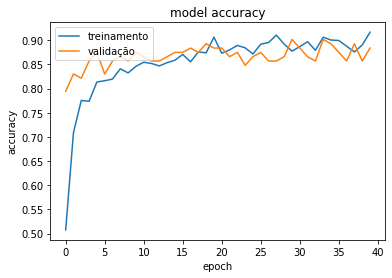

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


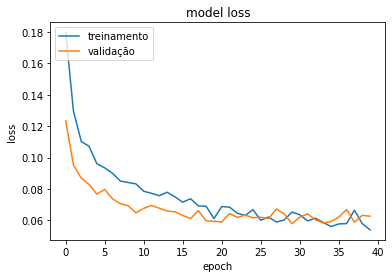

7/7 [==============================] - 3s 442ms/step


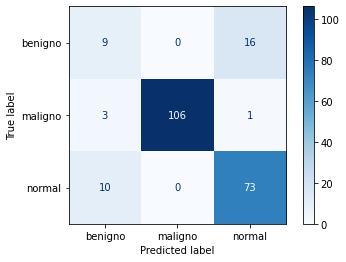

accuracy: 0.8623853211009175
              precision    recall  f1-score   support

     benigno       0.41      0.36      0.38        25
     maligno       1.00      0.96      0.98       110
      normal       0.81      0.88      0.84        83

    accuracy                           0.86       218
   macro avg       0.74      0.73      0.74       218
weighted avg       0.86      0.86      0.86       218

F1-score: 0.7361302802412957
specificity: 0.9355721870402354
sensitivity: 0.7343848119751734
AUC-ROC: 0.8964016064257029
\begin{tabular}{lrrrrr}
\hline
 Model     &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg       &   0.908257 &  0.842355 &      0.95742  &      0.848098 & 0.957711 \\
 densenet  &   0.857798 &  0.783273 &      0.936938 &      0.806878 & 0.924635 \\
 inception &   0.889908 &  0.816949 &      0.947176 &      0.823702 & 0.931593 \\
 xception  &   0.862385 &  0.73613  &      0.935572 &      0.734385 & 0.896402 \\
\hline
\end{tabular}


In [ ]:
run_full_model('xception', imgs, balance_data = True, balance_type = 'smote', data_augment = True)

# Hybrid Model

## Logistic Regression

### Sem balanceamento

4/4 [==============================] - 3s 1s/step


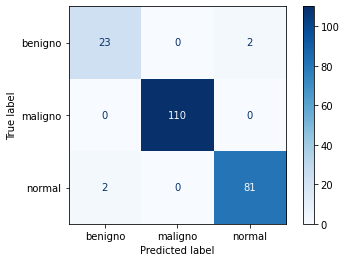

accuracy: 0.981651376146789
              precision    recall  f1-score   support

     benigno       0.92      0.92      0.92        25
     maligno       1.00      1.00      1.00       110
      normal       0.98      0.98      0.98        83

    accuracy                           0.98       218
   macro avg       0.97      0.97      0.97       218
weighted avg       0.98      0.98      0.98       218

F1-score: 0.9653012048192772
specificity: 0.9916074969615556
sensitivity: 0.9653012048192772
AUC-ROC: 0.987059510770354
\begin{tabular}{lrrrrr}
\hline
 Model   &   Acurracy &   F-score &   Specificity &   Sensitivity &     AUC \\
\hline
 vgg19   &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.98706 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model("vgg", 'LR', imgs)

4/4 [==============================] - 3s 831ms/step


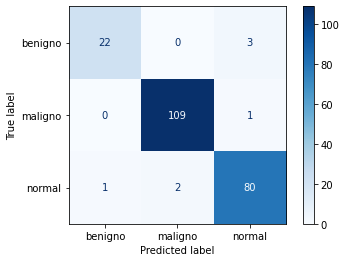

accuracy: 0.9678899082568807
              precision    recall  f1-score   support

     benigno       0.96      0.88      0.92        25
     maligno       0.98      0.99      0.99       110
      normal       0.95      0.96      0.96        83

    accuracy                           0.97       218
   macro avg       0.96      0.94      0.95       218
weighted avg       0.97      0.97      0.97       218

F1-score: 0.9537252794561706
specificity: 0.9822235015671975
sensitivity: 0.9449215041986126
AUC-ROC: 0.9983826213946697
\begin{tabular}{lrrrrr}
\hline
 Model    &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19    &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.98706  \\
 xception &   0.96789  &  0.953725 &      0.982224 &      0.944922 & 0.998383 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model('xception','LR', imgs)

4/4 [==============================] - 3s 1s/step


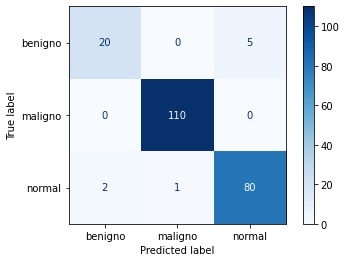

accuracy: 0.963302752293578
              precision    recall  f1-score   support

     benigno       0.91      0.80      0.85        25
     maligno       0.99      1.00      1.00       110
      normal       0.94      0.96      0.95        83

    accuracy                           0.96       218
   macro avg       0.95      0.92      0.93       218
weighted avg       0.96      0.96      0.96       218

F1-score: 0.9329732984301193
specificity: 0.9811136698010618
sensitivity: 0.9212851405622491
AUC-ROC: 0.9932931726907631
\begin{tabular}{lrrrrr}
\hline
 Model       &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19       &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.98706  \\
 xception    &   0.96789  &  0.953725 &      0.982224 &      0.944922 & 0.998383 \\
 densenet201 &   0.963303 &  0.932973 &      0.981114 &      0.921285 & 0.993293 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model('densenet', 'LR', imgs)

4/4 [==============================] - 2s 762ms/step


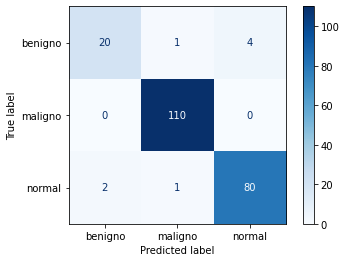

accuracy: 0.963302752293578
              precision    recall  f1-score   support

     benigno       0.91      0.80      0.85        25
     maligno       0.98      1.00      0.99       110
      normal       0.95      0.96      0.96        83

    accuracy                           0.96       218
   macro avg       0.95      0.92      0.93       218
weighted avg       0.96      0.96      0.96       218

F1-score: 0.9333795510378514
specificity: 0.9804963858504445
sensitivity: 0.9212851405622491
AUC-ROC: 0.9920102227090178
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.98706  \\
 xception     &   0.96789  &  0.953725 &      0.982224 &      0.944922 & 0.998383 \\
 densenet201  &   0.963303 &  0.932973 &      0.981114 &      0.921285 & 0.993293 \\
 inception_v3 &   0.963303 &  0.93338  &      0.980496 &      0.921285 & 0.99201  \\
\hline


In [ ]:
run_hybrid_model('inception', 'LR', imgs)

### Com balanceamento

#### Oversample

4/4 [==============================] - 1s 334ms/step


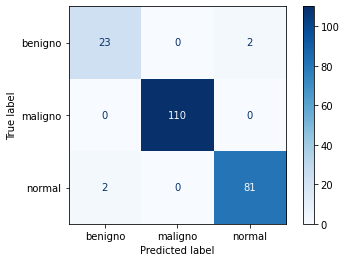

accuracy: 0.981651376146789
              precision    recall  f1-score   support

     benigno       0.92      0.92      0.92        25
     maligno       1.00      1.00      1.00       110
      normal       0.98      0.98      0.98        83

    accuracy                           0.98       218
   macro avg       0.97      0.97      0.97       218
weighted avg       0.98      0.98      0.98       218

F1-score: 0.9653012048192772
specificity: 0.9916074969615556
sensitivity: 0.9653012048192772
AUC-ROC: 0.9871653888280395
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.987165 \\
 xception     &   0.96789  &  0.953725 &      0.982224 &      0.944922 & 0.998383 \\
 densenet201  &   0.963303 &  0.932973 &      0.981114 &      0.921285 & 0.993293 \\
 inception_v3 &   0.963303 &  0.93338  &      0.980496 &      0.921285 & 0.99201  \\
\hline


In [ ]:
run_hybrid_model("vgg", 'LR', imgs, balance_data = True, balance_type = 'oversample')

4/4 [==============================] - 1s 440ms/step


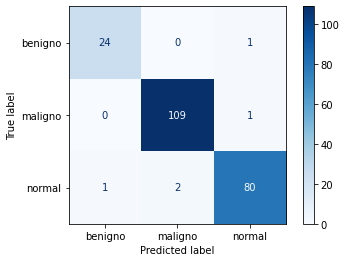

accuracy: 0.9770642201834863
              precision    recall  f1-score   support

     benigno       0.96      0.96      0.96        25
     maligno       0.98      0.99      0.99       110
      normal       0.98      0.96      0.97        83

    accuracy                           0.98       218
   macro avg       0.97      0.97      0.97       218
weighted avg       0.98      0.98      0.98       218

F1-score: 0.9720407696878285
specificity: 0.9871617731721359
sensitivity: 0.9715881708652793
AUC-ROC: 0.9986053304125594
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.987165 \\
 xception     &   0.977064 &  0.972041 &      0.987162 &      0.971588 & 0.998605 \\
 densenet201  &   0.963303 &  0.932973 &      0.981114 &      0.921285 & 0.993293 \\
 inception_v3 &   0.963303 &  0.93338  &      0.980496 &      0.921285 & 0.99201  \\
\hline

In [ ]:
run_hybrid_model('xception',  'LR',imgs, balance_data = True, balance_type = 'oversample')

4/4 [==============================] - 1s 232ms/step


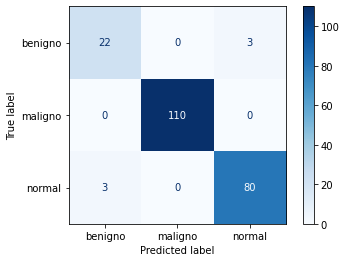

accuracy: 0.9724770642201835
              precision    recall  f1-score   support

     benigno       0.88      0.88      0.88        25
     maligno       1.00      1.00      1.00       110
      normal       0.96      0.96      0.96        83

    accuracy                           0.97       218
   macro avg       0.95      0.95      0.95       218
weighted avg       0.97      0.97      0.97       218

F1-score: 0.9479518072289156
specificity: 0.9874112454423335
sensitivity: 0.9479518072289156
AUC-ROC: 0.993424607520993
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.987165 \\
 xception     &   0.977064 &  0.972041 &      0.987162 &      0.971588 & 0.998605 \\
 densenet201  &   0.972477 &  0.947952 &      0.987411 &      0.947952 & 0.993425 \\
 inception_v3 &   0.963303 &  0.93338  &      0.980496 &      0.921285 & 0.99201  \\
\hline


In [ ]:
run_hybrid_model('densenet',  'LR',imgs, balance_data = True, balance_type = 'oversample')

4/4 [==============================] - 1s 191ms/step


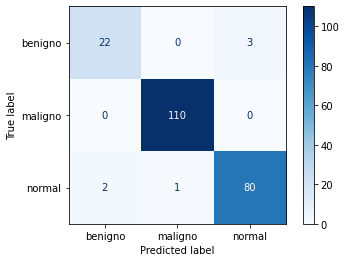

accuracy: 0.9724770642201835
              precision    recall  f1-score   support

     benigno       0.92      0.88      0.90        25
     maligno       0.99      1.00      1.00       110
      normal       0.96      0.96      0.96        83

    accuracy                           0.97       218
   macro avg       0.96      0.95      0.95       218
weighted avg       0.97      0.97      0.97       218

F1-score: 0.952429906160796
specificity: 0.986051941406
sensitivity: 0.9479518072289156
AUC-ROC: 0.9924921504198613
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.987165 \\
 xception     &   0.977064 &  0.972041 &      0.987162 &      0.971588 & 0.998605 \\
 densenet201  &   0.972477 &  0.947952 &      0.987411 &      0.947952 & 0.993425 \\
 inception_v3 &   0.972477 &  0.95243  &      0.986052 &      0.947952 & 0.992492 \\
\hline
\end

In [ ]:
run_hybrid_model('inception',  'LR',imgs, balance_data = True, balance_type = 'oversample')

#### SMOTE

4/4 [==============================] - 1s 331ms/step


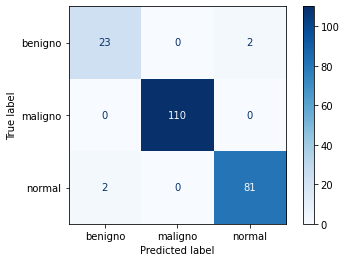

accuracy: 0.981651376146789
              precision    recall  f1-score   support

     benigno       0.92      0.92      0.92        25
     maligno       1.00      1.00      1.00       110
      normal       0.98      0.98      0.98        83

    accuracy                           0.98       218
   macro avg       0.97      0.97      0.97       218
weighted avg       0.98      0.98      0.98       218

F1-score: 0.9653012048192772
specificity: 0.9916074969615556
sensitivity: 0.9653012048192772
AUC-ROC: 0.9904775465498358
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.990478 \\
 xception     &   0.977064 &  0.972041 &      0.987162 &      0.971588 & 0.998605 \\
 densenet201  &   0.972477 &  0.947952 &      0.987411 &      0.947952 & 0.993425 \\
 inception_v3 &   0.972477 &  0.95243  &      0.986052 &      0.947952 & 0.992492 \\
\hline


In [ ]:
run_hybrid_model("vgg", 'LR', imgs, balance_data = True, balance_type = 'smote')

4/4 [==============================] - 1s 439ms/step


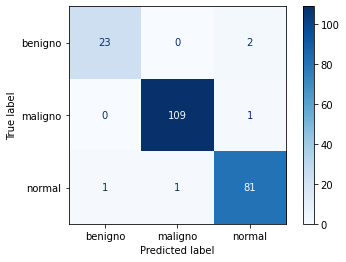

accuracy: 0.9770642201834863
              precision    recall  f1-score   support

     benigno       0.96      0.92      0.94        25
     maligno       0.99      0.99      0.99       110
      normal       0.96      0.98      0.97        83

    accuracy                           0.98       218
   macro avg       0.97      0.96      0.97       218
weighted avg       0.98      0.98      0.98       218

F1-score: 0.9665814937842313
specificity: 0.987779057122753
sensitivity: 0.9622709017889742
AUC-ROC: 0.9985958378970426
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.990478 \\
 xception     &   0.977064 &  0.966581 &      0.987779 &      0.962271 & 0.998596 \\
 densenet201  &   0.972477 &  0.947952 &      0.987411 &      0.947952 & 0.993425 \\
 inception_v3 &   0.972477 &  0.95243  &      0.986052 &      0.947952 & 0.992492 \\
\hline


In [ ]:
run_hybrid_model('xception', 'LR', imgs, balance_data = True, balance_type = 'smote')

4/4 [==============================] - 1s 232ms/step


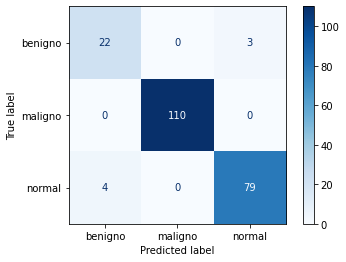

accuracy: 0.9678899082568807
              precision    recall  f1-score   support

     benigno       0.85      0.88      0.86        25
     maligno       1.00      1.00      1.00       110
      normal       0.96      0.95      0.96        83

    accuracy                           0.97       218
   macro avg       0.94      0.94      0.94       218
weighted avg       0.97      0.97      0.97       218

F1-score: 0.9401069518716577
specificity: 0.9856841297255805
sensitivity: 0.9439357429718874
AUC-ROC: 0.993574297188755
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.990478 \\
 xception     &   0.977064 &  0.966581 &      0.987779 &      0.962271 & 0.998596 \\
 densenet201  &   0.96789  &  0.940107 &      0.985684 &      0.943936 & 0.993574 \\
 inception_v3 &   0.972477 &  0.95243  &      0.986052 &      0.947952 & 0.992492 \\
\hline


In [ ]:
run_hybrid_model('densenet', 'LR', imgs, balance_data = True, balance_type = 'smote')

4/4 [==============================] - 1s 191ms/step


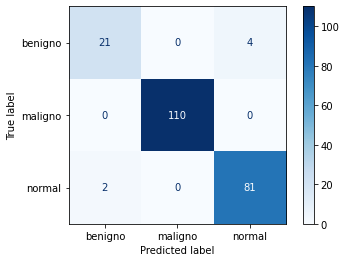

accuracy: 0.9724770642201835
              precision    recall  f1-score   support

     benigno       0.91      0.84      0.87        25
     maligno       1.00      1.00      1.00       110
      normal       0.95      0.98      0.96        83

    accuracy                           0.97       218
   macro avg       0.96      0.94      0.95       218
weighted avg       0.97      0.97      0.97       218

F1-score: 0.9464285714285715
specificity: 0.9866692253566174
sensitivity: 0.9386345381526104
AUC-ROC: 0.9946820007301934
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.990478 \\
 xception     &   0.977064 &  0.966581 &      0.987779 &      0.962271 & 0.998596 \\
 densenet201  &   0.96789  &  0.940107 &      0.985684 &      0.943936 & 0.993574 \\
 inception_v3 &   0.972477 &  0.946429 &      0.986669 &      0.938635 & 0.994682 \\
\hline

In [ ]:
run_hybrid_model('inception', 'LR', imgs, balance_data = True, balance_type = 'smote')

## KNN

### Sem balanceamento

4/4 [==============================] - 1s 334ms/step


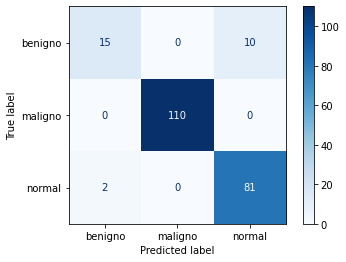

accuracy: 0.944954128440367
              precision    recall  f1-score   support

     benigno       0.88      0.60      0.71        25
     maligno       1.00      1.00      1.00       110
      normal       0.89      0.98      0.93        83

    accuracy                           0.94       218
   macro avg       0.92      0.86      0.88       218
weighted avg       0.94      0.94      0.94       218

F1-score: 0.8817733990147784
specificity: 0.9718544105418027
sensitivity: 0.8586345381526105
AUC-ROC: 0.9796641109894123
\begin{tabular}{lrrrrr}
\hline
 Model   &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19   &   0.944954 &  0.881773 &      0.971854 &      0.858635 & 0.979664 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model("vgg", 'KNN', imgs)

4/4 [==============================] - 1s 448ms/step


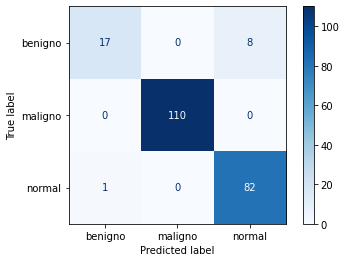

accuracy: 0.9587155963302753
              precision    recall  f1-score   support

     benigno       0.94      0.68      0.79        25
     maligno       1.00      1.00      1.00       110
      normal       0.91      0.99      0.95        83

    accuracy                           0.96       218
   macro avg       0.95      0.89      0.91       218
weighted avg       0.96      0.96      0.96       218

F1-score: 0.9128915176771072
specificity: 0.9785197978634939
sensitivity: 0.8893172690763053
AUC-ROC: 0.9714267981014969
\begin{tabular}{lrrrrr}
\hline
 Model    &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19    &   0.944954 &  0.881773 &      0.971854 &      0.858635 & 0.979664 \\
 xception &   0.958716 &  0.912892 &      0.97852  &      0.889317 & 0.971427 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model('xception', 'KNN', imgs)

4/4 [==============================] - 1s 235ms/step


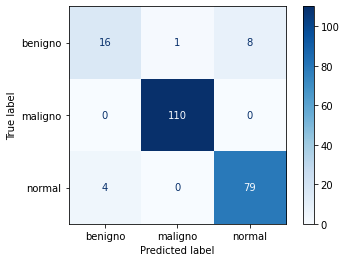

accuracy: 0.9403669724770642
              precision    recall  f1-score   support

     benigno       0.80      0.64      0.71        25
     maligno       0.99      1.00      1.00       110
      normal       0.91      0.95      0.93        83

    accuracy                           0.94       218
   macro avg       0.90      0.86      0.88       218
weighted avg       0.94      0.94      0.94       218

F1-score: 0.8786659963130551
specificity: 0.9702520309601484
sensitivity: 0.8639357429718876
AUC-ROC: 0.9844530850675429
\begin{tabular}{lrrrrr}
\hline
 Model       &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19       &   0.944954 &  0.881773 &      0.971854 &      0.858635 & 0.979664 \\
 xception    &   0.958716 &  0.912892 &      0.97852  &      0.889317 & 0.971427 \\
 densenet201 &   0.940367 &  0.878666 &      0.970252 &      0.863936 & 0.984453 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model('densenet', 'KNN', imgs)

4/4 [==============================] - 1s 194ms/step


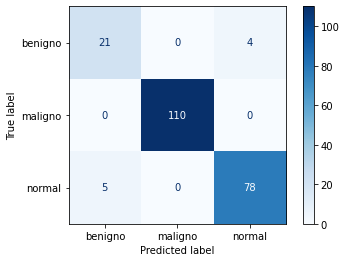

accuracy: 0.9587155963302753
              precision    recall  f1-score   support

     benigno       0.81      0.84      0.82        25
     maligno       1.00      1.00      1.00       110
      normal       0.95      0.94      0.95        83

    accuracy                           0.96       218
   macro avg       0.92      0.93      0.92       218
weighted avg       0.96      0.96      0.96       218

F1-score: 0.9229946524064171
specificity: 0.9814878782063583
sensitivity: 0.9265863453815261
AUC-ROC: 0.9821336254107339
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.944954 &  0.881773 &      0.971854 &      0.858635 & 0.979664 \\
 xception     &   0.958716 &  0.912892 &      0.97852  &      0.889317 & 0.971427 \\
 densenet201  &   0.940367 &  0.878666 &      0.970252 &      0.863936 & 0.984453 \\
 inception_v3 &   0.958716 &  0.922995 &      0.981488 &      0.926586 & 0.982134 \\
\hline

In [ ]:
run_hybrid_model('inception', 'KNN', imgs)

### Com balanceamento

#### Oversample

4/4 [==============================] - 1s 334ms/step


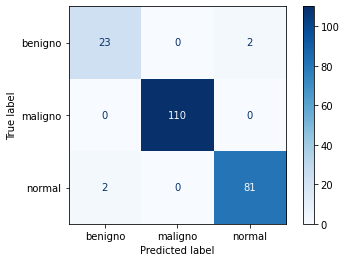

accuracy: 0.981651376146789
              precision    recall  f1-score   support

     benigno       0.92      0.92      0.92        25
     maligno       1.00      1.00      1.00       110
      normal       0.98      0.98      0.98        83

    accuracy                           0.98       218
   macro avg       0.97      0.97      0.97       218
weighted avg       0.98      0.98      0.98       218

F1-score: 0.9653012048192772
specificity: 0.9916074969615556
sensitivity: 0.9653012048192772
AUC-ROC: 0.9828769623950347
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.982877 \\
 xception     &   0.958716 &  0.912892 &      0.97852  &      0.889317 & 0.971427 \\
 densenet201  &   0.940367 &  0.878666 &      0.970252 &      0.863936 & 0.984453 \\
 inception_v3 &   0.958716 &  0.922995 &      0.981488 &      0.926586 & 0.982134 \\
\hline


In [ ]:
run_hybrid_model("vgg", 'KNN', imgs, balance_data = True, balance_type = 'oversample')

4/4 [==============================] - 1s 467ms/step


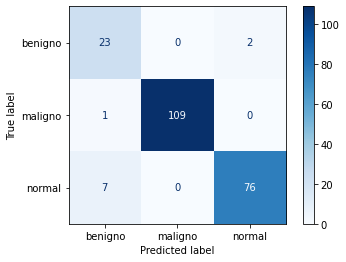

accuracy: 0.9541284403669725
              precision    recall  f1-score   support

     benigno       0.74      0.92      0.82        25
     maligno       1.00      0.99      1.00       110
      normal       0.97      0.92      0.94        83

    accuracy                           0.95       218
   macro avg       0.91      0.94      0.92       218
weighted avg       0.96      0.95      0.96       218

F1-score: 0.920320580088299
specificity: 0.9812448026610374
sensitivity: 0.9421905805038335
AUC-ROC: 0.9727455275648046
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.982877 \\
 xception     &   0.954128 &  0.920321 &      0.981245 &      0.942191 & 0.972746 \\
 densenet201  &   0.940367 &  0.878666 &      0.970252 &      0.863936 & 0.984453 \\
 inception_v3 &   0.958716 &  0.922995 &      0.981488 &      0.926586 & 0.982134 \\
\hline


In [ ]:
run_hybrid_model('xception', 'KNN', imgs, balance_data = True, balance_type = 'oversample')

4/4 [==============================] - 1s 243ms/step


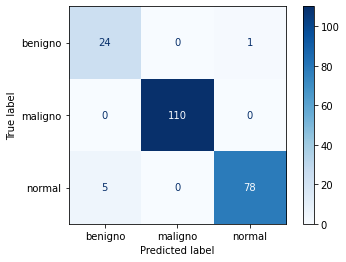

accuracy: 0.9724770642201835
              precision    recall  f1-score   support

     benigno       0.83      0.96      0.89        25
     maligno       1.00      1.00      1.00       110
      normal       0.99      0.94      0.96        83

    accuracy                           0.97       218
   macro avg       0.94      0.97      0.95       218
weighted avg       0.98      0.97      0.97       218

F1-score: 0.9506172839506174
specificity: 0.9888952856137657
sensitivity: 0.9665863453815261
AUC-ROC: 0.989324571011318
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.982877 \\
 xception     &   0.954128 &  0.920321 &      0.981245 &      0.942191 & 0.972746 \\
 densenet201  &   0.972477 &  0.950617 &      0.988895 &      0.966586 & 0.989325 \\
 inception_v3 &   0.958716 &  0.922995 &      0.981488 &      0.926586 & 0.982134 \\
\hline


In [ ]:
run_hybrid_model('densenet', 'KNN', imgs, balance_data = True, balance_type = 'oversample')

4/4 [==============================] - 1s 204ms/step


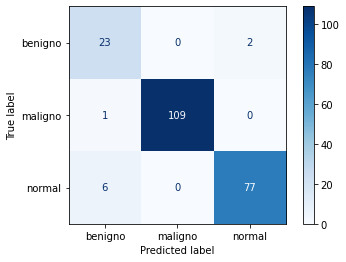

accuracy: 0.9587155963302753
              precision    recall  f1-score   support

     benigno       0.77      0.92      0.84        25
     maligno       1.00      0.99      1.00       110
      normal       0.97      0.93      0.95        83

    accuracy                           0.96       218
   macro avg       0.91      0.95      0.93       218
weighted avg       0.96      0.96      0.96       218

F1-score: 0.9274715700895305
specificity: 0.9829719183777904
sensitivity: 0.9462066447608617
AUC-ROC: 0.9803588901058781
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.982877 \\
 xception     &   0.954128 &  0.920321 &      0.981245 &      0.942191 & 0.972746 \\
 densenet201  &   0.972477 &  0.950617 &      0.988895 &      0.966586 & 0.989325 \\
 inception_v3 &   0.958716 &  0.927472 &      0.982972 &      0.946207 & 0.980359 \\
\hline

In [ ]:
run_hybrid_model('inception', 'KNN', imgs, balance_data = True, balance_type = 'oversample')

#### SMOTE

4/4 [==============================] - 1s 359ms/step


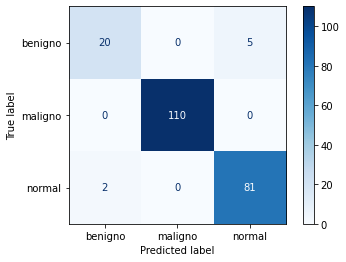

accuracy: 0.9678899082568807
              precision    recall  f1-score   support

     benigno       0.91      0.80      0.85        25
     maligno       1.00      1.00      1.00       110
      normal       0.94      0.98      0.96        83

    accuracy                           0.97       218
   macro avg       0.95      0.93      0.94       218
weighted avg       0.97      0.97      0.97       218

F1-score: 0.9365479038146797
specificity: 0.9842000895541482
sensitivity: 0.9253012048192771
AUC-ROC: 0.9846757940854326
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.96789  &  0.936548 &      0.9842   &      0.925301 & 0.984676 \\
 xception     &   0.954128 &  0.920321 &      0.981245 &      0.942191 & 0.972746 \\
 densenet201  &   0.972477 &  0.950617 &      0.988895 &      0.966586 & 0.989325 \\
 inception_v3 &   0.958716 &  0.927472 &      0.982972 &      0.946207 & 0.980359 \\
\hline

In [ ]:
run_hybrid_model("vgg", 'KNN', imgs, balance_data = True, balance_type = 'smote')

4/4 [==============================] - 2s 514ms/step


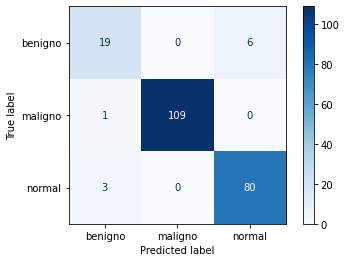

accuracy: 0.9541284403669725
              precision    recall  f1-score   support

     benigno       0.83      0.76      0.79        25
     maligno       1.00      0.99      1.00       110
      normal       0.93      0.96      0.95        83

    accuracy                           0.95       218
   macro avg       0.92      0.90      0.91       218
weighted avg       0.95      0.95      0.95       218

F1-score: 0.911282006250394
specificity: 0.9782767223181731
sensitivity: 0.9049215041986126
AUC-ROC: 0.9743621759766338
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.96789  &  0.936548 &      0.9842   &      0.925301 & 0.984676 \\
 xception     &   0.954128 &  0.911282 &      0.978277 &      0.904922 & 0.974362 \\
 densenet201  &   0.972477 &  0.950617 &      0.988895 &      0.966586 & 0.989325 \\
 inception_v3 &   0.958716 &  0.927472 &      0.982972 &      0.946207 & 0.980359 \\
\hline


In [ ]:
run_hybrid_model('xception', 'KNN', imgs, balance_data = True, balance_type = 'smote')

4/4 [==============================] - 1s 257ms/step


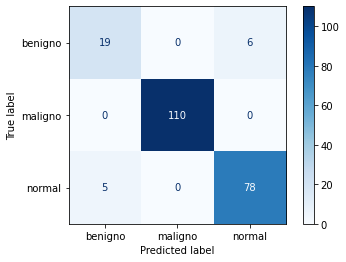

accuracy: 0.9495412844036697
              precision    recall  f1-score   support

     benigno       0.79      0.76      0.78        25
     maligno       1.00      1.00      1.00       110
      normal       0.93      0.94      0.93        83

    accuracy                           0.95       218
   macro avg       0.91      0.90      0.90       218
weighted avg       0.95      0.95      0.95       218

F1-score: 0.9032139802028597
specificity: 0.9765496066014201
sensitivity: 0.8999196787148595
AUC-ROC: 0.9762884264330047
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.96789  &  0.936548 &      0.9842   &      0.925301 & 0.984676 \\
 xception     &   0.954128 &  0.911282 &      0.978277 &      0.904922 & 0.974362 \\
 densenet201  &   0.949541 &  0.903214 &      0.97655  &      0.89992  & 0.976288 \\
 inception_v3 &   0.958716 &  0.927472 &      0.982972 &      0.946207 & 0.980359 \\
\hline

In [ ]:
run_hybrid_model('densenet', 'KNN', imgs, balance_data = True, balance_type = 'smote')

4/4 [==============================] - 1s 211ms/step


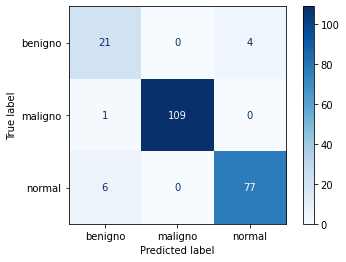

accuracy: 0.9495412844036697
              precision    recall  f1-score   support

     benigno       0.75      0.84      0.79        25
     maligno       1.00      0.99      1.00       110
      normal       0.95      0.93      0.94        83

    accuracy                           0.95       218
   macro avg       0.90      0.92      0.91       218
weighted avg       0.95      0.95      0.95       218

F1-score: 0.9089703367956399
specificity: 0.9780336467728522
sensitivity: 0.919539978094195
AUC-ROC: 0.9815494706097115
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.96789  &  0.936548 &      0.9842   &      0.925301 & 0.984676 \\
 xception     &   0.954128 &  0.911282 &      0.978277 &      0.904922 & 0.974362 \\
 densenet201  &   0.949541 &  0.903214 &      0.97655  &      0.89992  & 0.976288 \\
 inception_v3 &   0.949541 &  0.90897  &      0.978034 &      0.91954  & 0.981549 \\
\hline


In [ ]:
run_hybrid_model('inception', 'KNN', imgs, balance_data = True, balance_type = 'smote')

## SVM

### Sem balanceamento

4/4 [==============================] - 1s 377ms/step


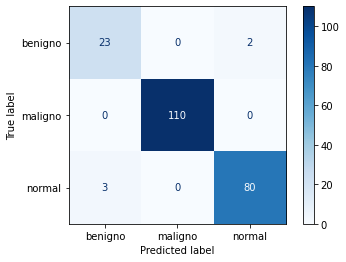

accuracy: 0.9770642201834863
              precision    recall  f1-score   support

     benigno       0.88      0.92      0.90        25
     maligno       1.00      1.00      1.00       110
      normal       0.98      0.96      0.97        83

    accuracy                           0.98       218
   macro avg       0.95      0.96      0.96       218
weighted avg       0.98      0.98      0.98       218

F1-score: 0.9572192513368986
specificity: 0.9898803812448026
sensitivity: 0.961285140562249
AUC-ROC: 0.9840146038700256
\begin{tabular}{lrrrrr}
\hline
 Model   &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19   &   0.977064 &  0.957219 &       0.98988 &      0.961285 & 0.984015 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model("vgg", 'SVM', imgs)

4/4 [==============================] - 2s 517ms/step


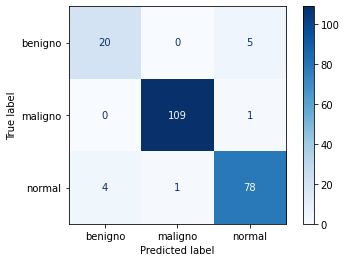

accuracy: 0.9495412844036697
              precision    recall  f1-score   support

     benigno       0.83      0.80      0.82        25
     maligno       0.99      0.99      0.99       110
      normal       0.93      0.94      0.93        83

    accuracy                           0.95       218
   macro avg       0.92      0.91      0.91       218
weighted avg       0.95      0.95      0.95       218

F1-score: 0.9137891193494273
specificity: 0.9751903025650868
sensitivity: 0.9102227090178898
AUC-ROC: 0.9875188024826579
\begin{tabular}{lrrrrr}
\hline
 Model    &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19    &   0.977064 &  0.957219 &       0.98988 &      0.961285 & 0.984015 \\
 xception &   0.949541 &  0.913789 &       0.97519 &      0.910223 & 0.987519 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model('xception', 'SVM', imgs)

4/4 [==============================] - 1s 258ms/step


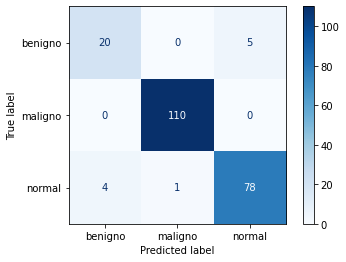

accuracy: 0.9541284403669725
              precision    recall  f1-score   support

     benigno       0.83      0.80      0.82        25
     maligno       0.99      1.00      1.00       110
      normal       0.94      0.94      0.94        83

    accuracy                           0.95       218
   macro avg       0.92      0.91      0.92       218
weighted avg       0.95      0.95      0.95       218

F1-score: 0.9171868932929984
specificity: 0.9776594383675558
sensitivity: 0.9132530120481928
AUC-ROC: 0.9865461847389558
\begin{tabular}{lrrrrr}
\hline
 Model       &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19       &   0.977064 &  0.957219 &      0.98988  &      0.961285 & 0.984015 \\
 xception    &   0.949541 &  0.913789 &      0.97519  &      0.910223 & 0.987519 \\
 densenet201 &   0.954128 &  0.917187 &      0.977659 &      0.913253 & 0.986546 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model('densenet', 'SVM', imgs)

4/4 [==============================] - 1s 213ms/step


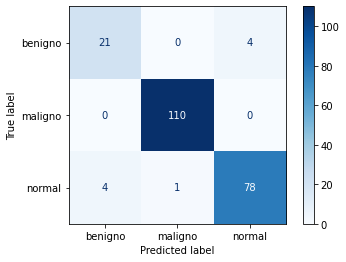

accuracy: 0.9587155963302753
              precision    recall  f1-score   support

     benigno       0.84      0.84      0.84        25
     maligno       0.99      1.00      1.00       110
      normal       0.95      0.94      0.95        83

    accuracy                           0.96       218
   macro avg       0.93      0.93      0.93       218
weighted avg       0.96      0.96      0.96       218

F1-score: 0.9269765528589057
specificity: 0.980128574170025
sensitivity: 0.9265863453815261
AUC-ROC: 0.9872858707557503
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.977064 &  0.957219 &      0.98988  &      0.961285 & 0.984015 \\
 xception     &   0.949541 &  0.913789 &      0.97519  &      0.910223 & 0.987519 \\
 densenet201  &   0.954128 &  0.917187 &      0.977659 &      0.913253 & 0.986546 \\
 inception_v3 &   0.958716 &  0.926977 &      0.980129 &      0.926586 & 0.987286 \\
\hline


In [ ]:
run_hybrid_model('inception', 'SVM', imgs)

### Com balanceamento

#### Oversample

4/4 [==============================] - 1s 383ms/step


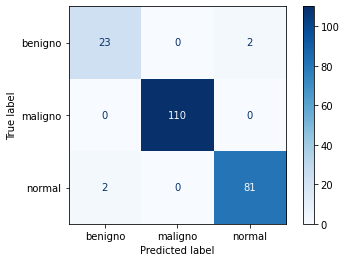

accuracy: 0.981651376146789
              precision    recall  f1-score   support

     benigno       0.92      0.92      0.92        25
     maligno       1.00      1.00      1.00       110
      normal       0.98      0.98      0.98        83

    accuracy                           0.98       218
   macro avg       0.97      0.97      0.97       218
weighted avg       0.98      0.98      0.98       218

F1-score: 0.9653012048192772
specificity: 0.9916074969615556
sensitivity: 0.9653012048192772
AUC-ROC: 0.9899795545819642
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.98998  \\
 xception     &   0.949541 &  0.913789 &      0.97519  &      0.910223 & 0.987519 \\
 densenet201  &   0.954128 &  0.917187 &      0.977659 &      0.913253 & 0.986546 \\
 inception_v3 &   0.958716 &  0.926977 &      0.980129 &      0.926586 & 0.987286 \\
\hline


In [ ]:
run_hybrid_model("vgg", 'SVM', imgs, balance_data = True, balance_type = 'oversample')

4/4 [==============================] - 2s 522ms/step


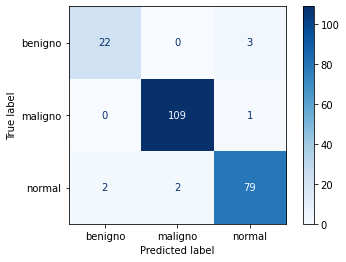

accuracy: 0.963302752293578
              precision    recall  f1-score   support

     benigno       0.92      0.88      0.90        25
     maligno       0.98      0.99      0.99       110
      normal       0.95      0.95      0.95        83

    accuracy                           0.96       218
   macro avg       0.95      0.94      0.95       218
weighted avg       0.96      0.96      0.96       218

F1-score: 0.9453972506518826
specificity: 0.9804963858504445
sensitivity: 0.9409054399415845
AUC-ROC: 0.9952756480467323
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.98998  \\
 xception     &   0.963303 &  0.945397 &      0.980496 &      0.940905 & 0.995276 \\
 densenet201  &   0.954128 &  0.917187 &      0.977659 &      0.913253 & 0.986546 \\
 inception_v3 &   0.958716 &  0.926977 &      0.980129 &      0.926586 & 0.987286 \\
\hline


In [ ]:
run_hybrid_model('xception', 'SVM', imgs, balance_data = True, balance_type = 'oversample')

4/4 [==============================] - 1s 238ms/step


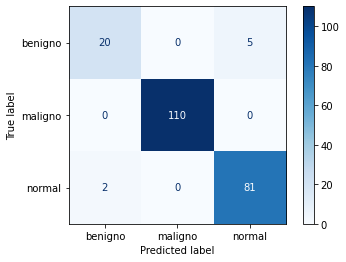

accuracy: 0.9678899082568807
              precision    recall  f1-score   support

     benigno       0.91      0.80      0.85        25
     maligno       1.00      1.00      1.00       110
      normal       0.94      0.98      0.96        83

    accuracy                           0.97       218
   macro avg       0.95      0.93      0.94       218
weighted avg       0.97      0.97      0.97       218

F1-score: 0.9365479038146797
specificity: 0.9842000895541482
sensitivity: 0.9253012048192771
AUC-ROC: 0.9932676159182184
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.98998  \\
 xception     &   0.963303 &  0.945397 &      0.980496 &      0.940905 & 0.995276 \\
 densenet201  &   0.96789  &  0.936548 &      0.9842   &      0.925301 & 0.993268 \\
 inception_v3 &   0.958716 &  0.926977 &      0.980129 &      0.926586 & 0.987286 \\
\hline

In [ ]:
run_hybrid_model('densenet', 'SVM', imgs, balance_data = True, balance_type = 'oversample')

4/4 [==============================] - 1s 196ms/step


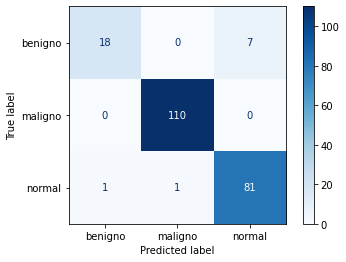

accuracy: 0.9587155963302753
              precision    recall  f1-score   support

     benigno       0.95      0.72      0.82        25
     maligno       0.99      1.00      1.00       110
      normal       0.92      0.98      0.95        83

    accuracy                           0.96       218
   macro avg       0.95      0.90      0.92       218
weighted avg       0.96      0.96      0.96       218

F1-score: 0.9203417841188738
specificity: 0.9779025139128766
sensitivity: 0.8986345381526104
AUC-ROC: 0.9907207009857611
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.98998  \\
 xception     &   0.963303 &  0.945397 &      0.980496 &      0.940905 & 0.995276 \\
 densenet201  &   0.96789  &  0.936548 &      0.9842   &      0.925301 & 0.993268 \\
 inception_v3 &   0.958716 &  0.920342 &      0.977903 &      0.898635 & 0.990721 \\
\hline

In [ ]:
run_hybrid_model('inception', 'SVM', imgs, balance_data = True, balance_type = 'oversample')

#### SMOTE

4/4 [==============================] - 1s 188ms/step


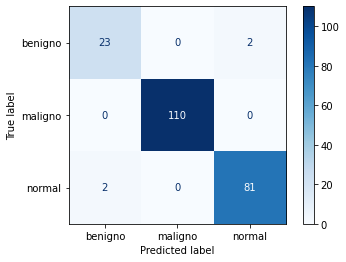

accuracy: 0.981651376146789
              precision    recall  f1-score   support

     benigno       0.92      0.92      0.92        25
     maligno       1.00      1.00      1.00       110
      normal       0.98      0.98      0.98        83

    accuracy                           0.98       218
   macro avg       0.97      0.97      0.97       218
weighted avg       0.98      0.98      0.98       218

F1-score: 0.9653012048192772
specificity: 0.9916074969615556
sensitivity: 0.9653012048192772
AUC-ROC: 0.9932814895947426
\begin{tabular}{lrrrrr}
\hline
 Model   &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19   &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.993281 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model("vgg", 'SVM', imgs, balance_data = True, balance_type = 'smote')

4/4 [==============================] - 1s 205ms/step


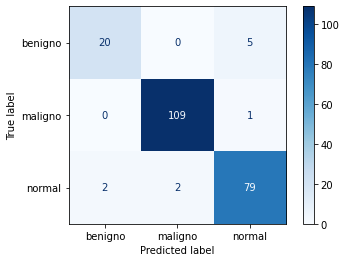

accuracy: 0.9541284403669725
              precision    recall  f1-score   support

     benigno       0.91      0.80      0.85        25
     maligno       0.98      0.99      0.99       110
      normal       0.93      0.95      0.94        83

    accuracy                           0.95       218
   macro avg       0.94      0.91      0.93       218
weighted avg       0.95      0.95      0.95       218

F1-score: 0.92598845320998
specificity: 0.9755581142455063
sensitivity: 0.9142387732749179
AUC-ROC: 0.9927900693683825
\begin{tabular}{lrrrrr}
\hline
 Model    &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19    &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.993281 \\
 xception &   0.954128 &  0.925988 &      0.975558 &      0.914239 & 0.99279  \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model('xception', 'SVM', imgs, balance_data = True, balance_type = 'smote')

4/4 [==============================] - 1s 385ms/step


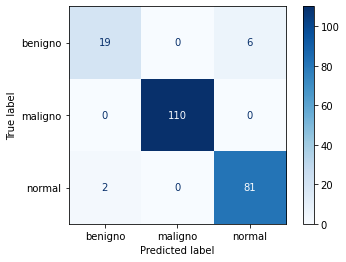

accuracy: 0.963302752293578
              precision    recall  f1-score   support

     benigno       0.90      0.76      0.83        25
     maligno       1.00      1.00      1.00       110
      normal       0.93      0.98      0.95        83

    accuracy                           0.96       218
   macro avg       0.95      0.91      0.93       218
weighted avg       0.96      0.96      0.96       218

F1-score: 0.9263427109974426
specificity: 0.9817309537516792
sensitivity: 0.9119678714859437
AUC-ROC: 0.9909090909090909
\begin{tabular}{lrrrrr}
\hline
 Model       &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19       &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.993281 \\
 xception    &   0.954128 &  0.925988 &      0.975558 &      0.914239 & 0.99279  \\
 densenet201 &   0.963303 &  0.926343 &      0.981731 &      0.911968 & 0.990909 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model('densenet', 'SVM', imgs, balance_data = True, balance_type = 'smote')

4/4 [==============================] - 1s 221ms/step


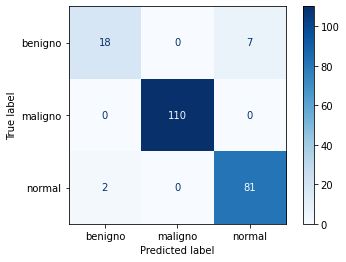

accuracy: 0.9587155963302753
              precision    recall  f1-score   support

     benigno       0.90      0.72      0.80        25
     maligno       1.00      1.00      1.00       110
      normal       0.92      0.98      0.95        83

    accuracy                           0.96       218
   macro avg       0.94      0.90      0.92       218
weighted avg       0.96      0.96      0.96       218

F1-score: 0.9157894736842104
specificity: 0.97926181794921
sensitivity: 0.8986345381526104
AUC-ROC: 0.9931982475355969
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.981651 &  0.965301 &      0.991607 &      0.965301 & 0.993281 \\
 xception     &   0.954128 &  0.925988 &      0.975558 &      0.914239 & 0.99279  \\
 densenet201  &   0.963303 &  0.926343 &      0.981731 &      0.911968 & 0.990909 \\
 inception_v3 &   0.958716 &  0.915789 &      0.979262 &      0.898635 & 0.993198 \\
\hline
\

In [ ]:
run_hybrid_model('inception', 'SVM', imgs, balance_data = True, balance_type = 'smote')

## Decision Tree

### Sem balanceamento

4/4 [==============================] - 0s 34ms/step


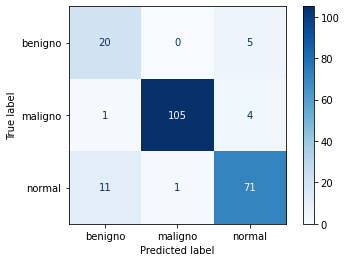

accuracy: 0.8990825688073395
              precision    recall  f1-score   support

     benigno       0.62      0.80      0.70        25
     maligno       0.99      0.95      0.97       110
      normal       0.89      0.86      0.87        83

    accuracy                           0.90       218
   macro avg       0.83      0.87      0.85       218
weighted avg       0.91      0.90      0.90       218

F1-score: 0.8483807507863045
specificity: 0.953965969423655
sensitivity: 0.8699890470974809
AUC-ROC: 0.9024917853231106
\begin{tabular}{lrrrrr}
\hline
 Model   &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19   &   0.899083 &  0.848381 &      0.953966 &      0.869989 & 0.902492 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model("vgg", 'DT', imgs)

4/4 [==============================] - 0s 58ms/step


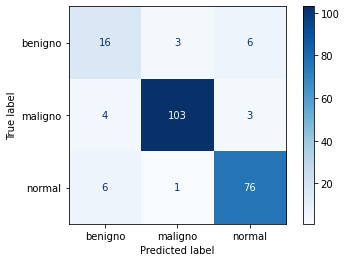

accuracy: 0.8944954128440367
              precision    recall  f1-score   support

     benigno       0.62      0.64      0.63        25
     maligno       0.96      0.94      0.95       110
      normal       0.89      0.92      0.90        83

    accuracy                           0.89       218
   macro avg       0.82      0.83      0.83       218
weighted avg       0.90      0.89      0.90       218

F1-score: 0.8271738803048101
specificity: 0.9481609415979019
sensitivity: 0.8306754289886821
AUC-ROC: 0.8730065717415115
\begin{tabular}{lrrrrr}
\hline
 Model    &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19    &   0.899083 &  0.848381 &      0.953966 &      0.869989 & 0.902492 \\
 xception &   0.894495 &  0.827174 &      0.948161 &      0.830675 & 0.873007 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model('xception', 'DT', imgs)

4/4 [==============================] - 0s 47ms/step


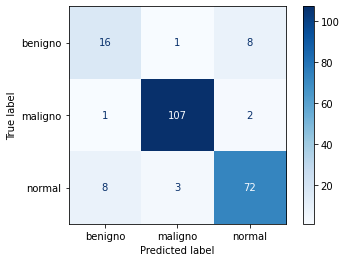

accuracy: 0.8944954128440367
              precision    recall  f1-score   support

     benigno       0.64      0.64      0.64        25
     maligno       0.96      0.97      0.97       110
      normal       0.88      0.87      0.87        83

    accuracy                           0.89       218
   macro avg       0.83      0.83      0.83       218
weighted avg       0.89      0.89      0.89       218

F1-score: 0.8270176881941588
specificity: 0.9474189215121857
sensitivity: 0.8267323840817817
AUC-ROC: 0.8700492880613363
\begin{tabular}{lrrrrr}
\hline
 Model       &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19       &   0.899083 &  0.848381 &      0.953966 &      0.869989 & 0.902492 \\
 xception    &   0.894495 &  0.827174 &      0.948161 &      0.830675 & 0.873007 \\
 densenet201 &   0.894495 &  0.827018 &      0.947419 &      0.826732 & 0.870049 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model('densenet', 'DT', imgs)

4/4 [==============================] - 0s 37ms/step


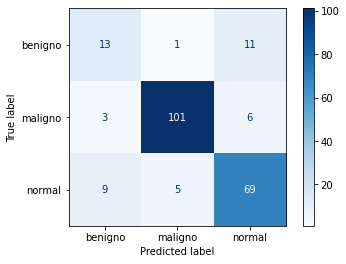

accuracy: 0.8394495412844036
              precision    recall  f1-score   support

     benigno       0.52      0.52      0.52        25
     maligno       0.94      0.92      0.93       110
      normal       0.80      0.83      0.82        83

    accuracy                           0.84       218
   macro avg       0.76      0.76      0.76       218
weighted avg       0.84      0.84      0.84       218

F1-score: 0.7558145411247148
specificity: 0.91878078423847
sensitivity: 0.7565023731288791
AUC-ROC: 0.8173767798466595
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.899083 &  0.848381 &      0.953966 &      0.869989 & 0.902492 \\
 xception     &   0.894495 &  0.827174 &      0.948161 &      0.830675 & 0.873007 \\
 densenet201  &   0.894495 &  0.827018 &      0.947419 &      0.826732 & 0.870049 \\
 inception_v3 &   0.83945  &  0.755815 &      0.918781 &      0.756502 & 0.817377 \\
\hline
\

In [ ]:
run_hybrid_model('inception', 'DT', imgs)

### Com balanceamento

#### Oversample

4/4 [==============================] - 0s 33ms/step


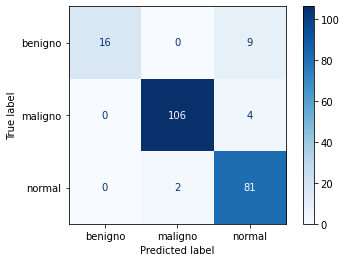

accuracy: 0.9311926605504587
              precision    recall  f1-score   support

     benigno       1.00      0.64      0.78        25
     maligno       0.98      0.96      0.97       110
      normal       0.86      0.98      0.92        83

    accuracy                           0.93       218
   macro avg       0.95      0.86      0.89       218
weighted avg       0.94      0.93      0.93       218

F1-score: 0.889406368795456
specificity: 0.9617283950617285
sensitivity: 0.8598466593647317
AUC-ROC: 0.8948849945235487
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.931193 &  0.889406 &      0.961728 &      0.859847 & 0.894885 \\
 xception     &   0.894495 &  0.827174 &      0.948161 &      0.830675 & 0.873007 \\
 densenet201  &   0.894495 &  0.827018 &      0.947419 &      0.826732 & 0.870049 \\
 inception_v3 &   0.83945  &  0.755815 &      0.918781 &      0.756502 & 0.817377 \\
\hline


In [ ]:
run_hybrid_model("vgg", 'DT', imgs, balance_data = True, balance_type = 'oversample')

4/4 [==============================] - 0s 59ms/step


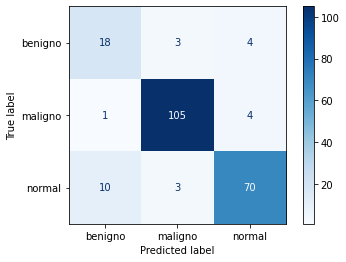

accuracy: 0.8853211009174312
              precision    recall  f1-score   support

     benigno       0.62      0.72      0.67        25
     maligno       0.95      0.95      0.95       110
      normal       0.90      0.84      0.87        83

    accuracy                           0.89       218
   macro avg       0.82      0.84      0.83       218
weighted avg       0.89      0.89      0.89       218

F1-score: 0.8288193761339541
specificity: 0.9427301221774451
sensitivity: 0.839306316173786
AUC-ROC: 0.8794797371303394
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.931193 &  0.889406 &      0.961728 &      0.859847 & 0.894885 \\
 xception     &   0.885321 &  0.828819 &      0.94273  &      0.839306 & 0.87948  \\
 densenet201  &   0.894495 &  0.827018 &      0.947419 &      0.826732 & 0.870049 \\
 inception_v3 &   0.83945  &  0.755815 &      0.918781 &      0.756502 & 0.817377 \\
\hline


In [ ]:
run_hybrid_model('xception', 'DT', imgs, balance_data = True, balance_type = 'oversample')

4/4 [==============================] - 0s 46ms/step


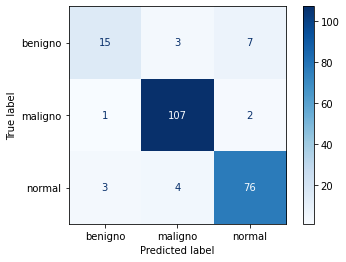

accuracy: 0.908256880733945
              precision    recall  f1-score   support

     benigno       0.79      0.60      0.68        25
     maligno       0.94      0.97      0.96       110
      normal       0.89      0.92      0.90        83

    accuracy                           0.91       218
   macro avg       0.87      0.83      0.85       218
weighted avg       0.90      0.91      0.90       218

F1-score: 0.8473124098124099
specificity: 0.9492643766391607
sensitivity: 0.8294633077765607
AUC-ROC: 0.8720974808324206
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.931193 &  0.889406 &      0.961728 &      0.859847 & 0.894885 \\
 xception     &   0.885321 &  0.828819 &      0.94273  &      0.839306 & 0.87948  \\
 densenet201  &   0.908257 &  0.847312 &      0.949264 &      0.829463 & 0.872097 \\
 inception_v3 &   0.83945  &  0.755815 &      0.918781 &      0.756502 & 0.817377 \\
\hline


In [ ]:
run_hybrid_model('densenet', 'DT', imgs, balance_data = True, balance_type = 'oversample')

4/4 [==============================] - 0s 37ms/step


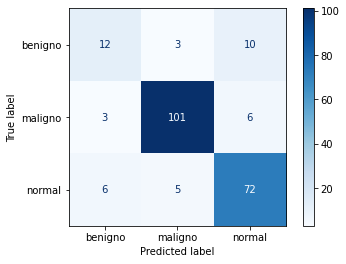

accuracy: 0.8486238532110092
              precision    recall  f1-score   support

     benigno       0.57      0.48      0.52        25
     maligno       0.93      0.92      0.92       110
      normal       0.82      0.87      0.84        83

    accuracy                           0.85       218
   macro avg       0.77      0.76      0.76       218
weighted avg       0.84      0.85      0.85       218

F1-score: 0.7620729409388072
specificity: 0.9202584276850253
sensitivity: 0.7552172325666301
AUC-ROC: 0.8164129244249727
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.931193 &  0.889406 &      0.961728 &      0.859847 & 0.894885 \\
 xception     &   0.885321 &  0.828819 &      0.94273  &      0.839306 & 0.87948  \\
 densenet201  &   0.908257 &  0.847312 &      0.949264 &      0.829463 & 0.872097 \\
 inception_v3 &   0.848624 &  0.762073 &      0.920258 &      0.755217 & 0.816413 \\
\hline

In [ ]:
run_hybrid_model('inception', 'DT', imgs, balance_data = True, balance_type = 'oversample')

#### SMOTE

4/4 [==============================] - 0s 33ms/step


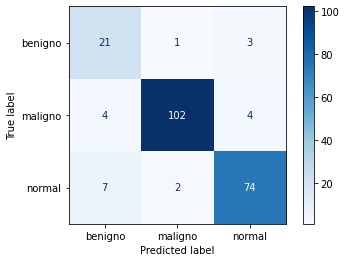

accuracy: 0.9036697247706422
              precision    recall  f1-score   support

     benigno       0.66      0.84      0.74        25
     maligno       0.97      0.93      0.95       110
      normal       0.91      0.89      0.90        83

    accuracy                           0.90       218
   macro avg       0.85      0.89      0.86       218
weighted avg       0.91      0.90      0.91       218

F1-score: 0.8627061129852424
specificity: 0.9544585172391735
sensitivity: 0.8862796641109894
AUC-ROC: 0.9147097480832421
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.90367  &  0.862706 &      0.954459 &      0.88628  & 0.91471  \\
 xception     &   0.885321 &  0.828819 &      0.94273  &      0.839306 & 0.87948  \\
 densenet201  &   0.908257 &  0.847312 &      0.949264 &      0.829463 & 0.872097 \\
 inception_v3 &   0.848624 &  0.762073 &      0.920258 &      0.755217 & 0.816413 \\
\hline

In [ ]:
run_hybrid_model("vgg", 'DT', imgs, balance_data = True, balance_type = 'smote')

4/4 [==============================] - 0s 59ms/step


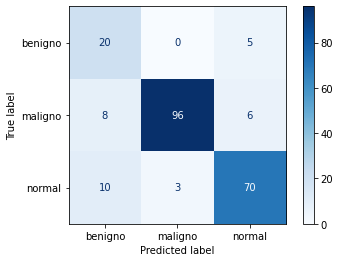

accuracy: 0.8532110091743119
              precision    recall  f1-score   support

     benigno       0.53      0.80      0.63        25
     maligno       0.97      0.87      0.92       110
      normal       0.86      0.84      0.85        83

    accuracy                           0.85       218
   macro avg       0.79      0.84      0.80       218
weighted avg       0.88      0.85      0.86       218

F1-score: 0.8024131528624467
specificity: 0.9324921640120257
sensitivity: 0.8387002555677254
AUC-ROC: 0.8790251916757942
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.90367  &  0.862706 &      0.954459 &      0.88628  & 0.91471  \\
 xception     &   0.853211 &  0.802413 &      0.932492 &      0.8387   & 0.879025 \\
 densenet201  &   0.908257 &  0.847312 &      0.949264 &      0.829463 & 0.872097 \\
 inception_v3 &   0.848624 &  0.762073 &      0.920258 &      0.755217 & 0.816413 \\
\hline

In [ ]:
run_hybrid_model('xception', 'DT', imgs, balance_data = True, balance_type = 'smote')

4/4 [==============================] - 0s 46ms/step


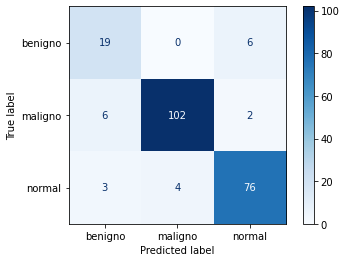

accuracy: 0.9036697247706422
              precision    recall  f1-score   support

     benigno       0.68      0.76      0.72        25
     maligno       0.96      0.93      0.94       110
      normal       0.90      0.92      0.91        83

    accuracy                           0.90       218
   macro avg       0.85      0.87      0.86       218
weighted avg       0.91      0.90      0.91       218

F1-score: 0.857201739079493
specificity: 0.9523571931171241
sensitivity: 0.867645125958379
AUC-ROC: 0.9007338444687841
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.90367  &  0.862706 &      0.954459 &      0.88628  & 0.91471  \\
 xception     &   0.853211 &  0.802413 &      0.932492 &      0.8387   & 0.879025 \\
 densenet201  &   0.90367  &  0.857202 &      0.952357 &      0.867645 & 0.900734 \\
 inception_v3 &   0.848624 &  0.762073 &      0.920258 &      0.755217 & 0.816413 \\
\hline
\

In [ ]:
run_hybrid_model('densenet', 'DT', imgs, balance_data = True, balance_type = 'smote')

4/4 [==============================] - 0s 38ms/step


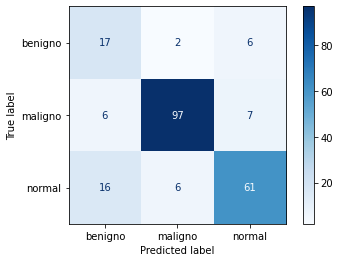

accuracy: 0.8027522935779816
              precision    recall  f1-score   support

     benigno       0.44      0.68      0.53        25
     maligno       0.92      0.88      0.90       110
      normal       0.82      0.73      0.78        83

    accuracy                           0.80       218
   macro avg       0.73      0.77      0.74       218
weighted avg       0.83      0.80      0.81       218

F1-score: 0.7368818816965389
specificity: 0.9052133307746434
sensitivity: 0.7655859802847754
AUC-ROC: 0.8241894852135817
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.90367  &  0.862706 &      0.954459 &      0.88628  & 0.91471  \\
 xception     &   0.853211 &  0.802413 &      0.932492 &      0.8387   & 0.879025 \\
 densenet201  &   0.90367  &  0.857202 &      0.952357 &      0.867645 & 0.900734 \\
 inception_v3 &   0.802752 &  0.736882 &      0.905213 &      0.765586 & 0.824189 \\
\hline

In [ ]:
run_hybrid_model('inception', 'DT', imgs, balance_data = True, balance_type = 'smote')

## STOCASTIC GRADIENT DESCENT

### Sem balanceamento

4/4 [==============================] - 0s 34ms/step


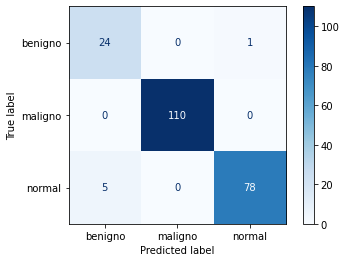

accuracy: 0.9724770642201835
              precision    recall  f1-score   support

     benigno       0.83      0.96      0.89        25
     maligno       1.00      1.00      1.00       110
      normal       0.99      0.94      0.96        83

    accuracy                           0.97       218
   macro avg       0.94      0.97      0.95       218
weighted avg       0.98      0.97      0.97       218

F1-score: 0.9506172839506174
specificity: 0.9888952856137657
sensitivity: 0.9665863453815261
AUC-ROC: 0.9862650602409638
\begin{tabular}{lrrrrr}
\hline
 Model   &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19   &   0.972477 &  0.950617 &      0.988895 &      0.966586 & 0.986265 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model("vgg", 'SGDC', imgs)

4/4 [==============================] - 0s 60ms/step


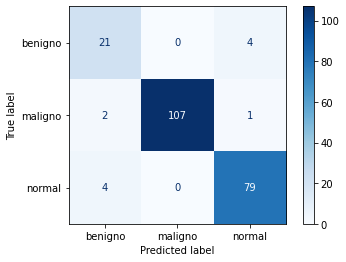

accuracy: 0.9495412844036697
              precision    recall  f1-score   support

     benigno       0.78      0.84      0.81        25
     maligno       1.00      0.97      0.99       110
      normal       0.94      0.95      0.95        83

    accuracy                           0.95       218
   macro avg       0.91      0.92      0.91       218
weighted avg       0.95      0.95      0.95       218

F1-score: 0.9133250691102729
specificity: 0.9772916266871361
sensitivity: 0.9215115005476452
AUC-ROC: 0.9504804673238407
\begin{tabular}{lrrrrr}
\hline
 Model    &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19    &   0.972477 &  0.950617 &      0.988895 &      0.966586 & 0.986265 \\
 xception &   0.949541 &  0.913325 &      0.977292 &      0.921512 & 0.95048  \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model('xception', 'SGDC', imgs)

4/4 [==============================] - 0s 49ms/step


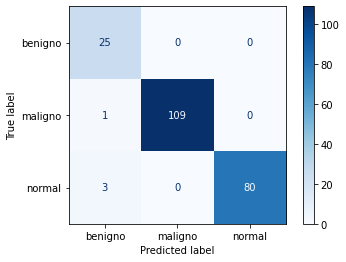

accuracy: 0.981651376146789
              precision    recall  f1-score   support

     benigno       0.86      1.00      0.93        25
     maligno       1.00      0.99      1.00       110
      normal       1.00      0.96      0.98        83

    accuracy                           0.98       218
   macro avg       0.95      0.98      0.97       218
weighted avg       0.98      0.98      0.98       218

F1-score: 0.9676516026349345
specificity: 0.9930915371329879
sensitivity: 0.9849215041986126
AUC-ROC: 0.9928784227820372
\begin{tabular}{lrrrrr}
\hline
 Model       &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19       &   0.972477 &  0.950617 &      0.988895 &      0.966586 & 0.986265 \\
 xception    &   0.949541 &  0.913325 &      0.977292 &      0.921512 & 0.95048  \\
 densenet201 &   0.981651 &  0.967652 &      0.993092 &      0.984922 & 0.992878 \\
\hline
\end{tabular}


In [ ]:
run_hybrid_model('densenet', 'SGDC', imgs)

4/4 [==============================] - 0s 38ms/step


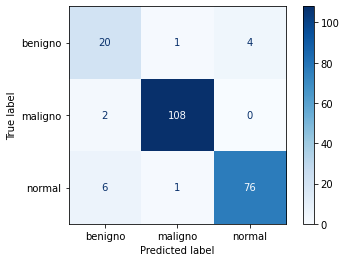

accuracy: 0.9357798165137615
              precision    recall  f1-score   support

     benigno       0.71      0.80      0.75        25
     maligno       0.98      0.98      0.98       110
      normal       0.95      0.92      0.93        83

    accuracy                           0.94       218
   macro avg       0.88      0.90      0.89       218
weighted avg       0.94      0.94      0.94       218

F1-score: 0.8896835001245234
specificity: 0.9701336915499263
sensitivity: 0.8991602774735304
AUC-ROC: 0.9370419861263235
\begin{tabular}{lrrrrr}
\hline
 Model        &   Acurracy &   F-score &   Specificity &   Sensitivity &      AUC \\
\hline
 vgg19        &   0.972477 &  0.950617 &      0.988895 &      0.966586 & 0.986265 \\
 xception     &   0.949541 &  0.913325 &      0.977292 &      0.921512 & 0.95048  \\
 densenet201  &   0.981651 &  0.967652 &      0.993092 &      0.984922 & 0.992878 \\
 inception_v3 &   0.93578  &  0.889684 &      0.970134 &      0.89916  & 0.937042 \\
\hline

In [ ]:
run_hybrid_model('inception', 'SGDC', imgs)

### Com balanceamento

#### Oversample

In [ ]:
run_hybrid_model("vgg", 'SGDC', imgs, balance_data = True, balance_type = 'oversample')

In [ ]:
run_hybrid_model('xception', 'SGDC', imgs, balance_data = True, balance_type = 'oversample')

In [ ]:
run_hybrid_model('densenet', 'SGDC', imgs, balance_data = True, balance_type = 'oversample')

In [ ]:
run_hybrid_model('inception', 'SGDC', imgs, balance_data = True, balance_type = 'oversample')

#### SMOTE

In [ ]:
run_hybrid_model("vgg", 'SGDC', imgs, balance_data = True, balance_type = 'smote')

In [ ]:
run_hybrid_model('xception', 'SGDC', imgs, balance_data = True, balance_type = 'smote')

In [ ]:
run_hybrid_model('densenet', 'SGDC', imgs, balance_data = True, balance_type = 'smote')

In [ ]:
run_hybrid_model('inception', 'SGDC', imgs, balance_data = True, balance_type = 'smote')